# Model to detect data exfiltration using clustering

## 0. Import Libraries

### 0.1. Standard Library

In [2]:
from dataclasses import (
    dataclass,
    replace,
)
import os
from pathlib import Path
from typing import (
    Literal,
)
import logging
import random
import shutil

### 0.2. External Libraries

In [3]:
from polars import selectors as cs
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim

## 1. Setup

### 1.1. Set Constants

#### 1.1.1. User Modifiable Constants

In [4]:
# Name of the dataset file to be downloaded/used
DATASET_ROOT: Path = Path("data")
DATASET_PATH: Path = DATASET_ROOT / "dataset.csv"

# S3 Configuration
USE_S3: bool = False
S3_BUCKET_NAME: str = "logs-pobl"
S3_DATASET_KEY: str = "merged-logs/merged.csv"
S3_MODELS_PREFIX: str = "production_models/"
LOW_VARIANCE_THRESHOLD: float = 0.01

PARAMETER_TUNING: bool = False

# Log file path
LOG_PATH: Path | None = (
    Path
        .cwd()
        .joinpath("classifier-test.log")
)

# Test against one-hot encoding.
PORT_PREPROCESSING_ONE_HOT: bool = True

# Correlation coefficient threshold for feature removal during preprocessing.
# Features with absolute correlation above this value (0.8) are considered highly correlated.
# During preprocessing, when two features exceed this threshold, one will be removed to reduce multicollinearity.
# Higher values (>0.8) are more conservative, removing only very strongly correlated features.
# Lower values (<0.8) are more aggressive, potentially removing more features.
# The value 0.8 is a common choice that balances information preservation with redundancy removal.
PREPROCESSING_CORRELATION_THRESHOLD: float = 0.8

# Correlation threshold for detecting potential data leakage during preprocessing.
# Features with absolute correlation coefficients >= 0.5 with the target variable
# are considered suspicious and may represent leaked information.
# Using 0.5 is a conservative approach that can catch moderate correlations:
# - 0.8-1.0: Very strong correlation (definite leakage concern)
# - 0.6-0.8: Strong correlation (highly suspicious)
# - 0.5-0.6: Moderate correlation (potentially problematic)
# Consider adjusting based on domain knowledge and model performance.
PREPROCESSING_LEAKAGE_CORRELATION_THRESHOLD: float = 0.5

# Random seed for reproducibility (None for random behavior)
SEED: int | None = 42

# Whether to show output during processing
SHOW_OUTPUT: bool = True

#### 1.1.2. User Non-Modifiable Constants

In [5]:
DATASET_PATH: Path = Path("dataset.csv")

### 1.2. Setup Logging

In [6]:
logging.basicConfig(
    level=logging.INFO
)

## 2. Import Data

### 2.1. Get Dataset

To learn more about the dataset, we have visited the github page of the zeek package we download, where every feature is explained. The process of getting the dataset is documented in the memory, it's a merge of data gotten from Zeek and Zeek-flowmeter. For more information about the features we can visit https://github.com/zeek-flowmeter/zeek-flowmeter

#### 2.1.1. Download Dataset

In [7]:
##Logica de descargar de s3


def download_from_s3(bucket, s3_key, local_path):
    if not USE_S3:
        print("Skipping s3 download")
        return

    import boto3
    from botocore.exceptions import NoCredentialsError
    try:
        s3 = boto3.client('s3')
        print(f"Downloading {s3_key} from {bucket}")
        s3.download_file(bucket, s3_key, str(local_path))
        print(f"File saved at {local_path}")
    except NoCredentialsError:
        print("AWS not configured")
    except Exception as e:
        print(f"Error downloading from s3: {e}")

download_from_s3(S3_BUCKET_NAME, S3_DATASET_KEY, DATASET_PATH)

Skipping s3 download


#### 2.1.2. Prepare Dataset

In [8]:
# Esto abrirá un botoncito para que subas tu 'dataset.csv' desde tu PC
LAZYFRAME = pl.scan_csv(
    DATASET_PATH,
    null_values="NaN",
    infer_schema=True,
    infer_schema_length=None,
    rechunk=True,
    truncate_ragged_lines=True,
    separator=",",
)


In [9]:
# display(LAZYFRAME.head(5).collect())

# display(LAZYFRAME.describe())


## 3. Basic Preprocessing

Before we start using our data, we need to preprocess it

### 3.1. Drop Features that are completely null

Handling missing values is a critical step in data preprocessing. Features containing null values can introduce bias and cause runtime errors during model training. Since the dataset is sufficiently large, removing these incomplete records ensures data integrity without significantly reducing the statistical power of the sample

In [10]:
n_rows = LAZYFRAME.select(pl.len()).collect().item()

nulls = LAZYFRAME.select(pl.all().null_count()).collect().row(0)

cols_to_keep = [
    c for c, n in zip(LAZYFRAME.columns, nulls)
    if n < n_rows
]

LAZYFRAME = LAZYFRAME.select(cols_to_keep)


/tmp/ipython-input-2937434487.py:6: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  c for c, n in zip(LAZYFRAME.columns, nulls)


### 3.2. Handle Infinity Values

Infinite values (often caused by division by zero in flow feature calculations) are mathematically unusable for most machine learning algorithms because they disrupt distance calculations and gradient descents. We filter them out to ensure numerical stability.

In [11]:
LAZYFRAME = (
    LAZYFRAME
        .filter(
            pl.all_horizontal(
                cs.numeric()
                    .is_finite()
            )
        )
)

### 3.3. Handle Negative Protocol Header Lengths

The header length is a measure of the size of the headers, which cannot logically be negative or 0 in real-world scenarios. Negative or 0 values might indicate an issue, such as a bug in the software or incorrect packet parsing in the flow data being captured.

In [12]:
LAZYFRAME = (
    LAZYFRAME
        .filter(
            pl.all_horizontal(
                pl.col(r"^(Fwd|Bwd) Header Length$") > 0
            )
        )
)

### 3.4. Drop IP Addresses and Source Port

IP addresses (id.orig_h, id.resp_h) and ephemeral source ports (id.orig_p) are high-cardinality categorical identifiers. Including them can lead to the model learning specific "identities" rather than "behaviors" (attacks). For a generalizable intrusion detection system, we want the model to learn how the traffic looks (features), not who sent it.

In [13]:
LAZYFRAME = (
    LAZYFRAME
        .drop([
            "id.orig_h",
            "id.resp_h",
            "id.orig_p",
            "id.resp_p",
        ])
)

### 3.5. Drop Identification Columns

The uid is a unique identifier for the connection log and carries no predictive information about the traffic's nature. Retaining it adds noise and dimensionality without adding value.

In [14]:
LAZYFRAME = (
    LAZYFRAME
        .drop(
            "uid",
        )
)

### 3.6. Drop Timestamp Column

Clustering algorithms normally work with mathematical distances. They cannot calculate the distance between text strings such as “03/07/2017.” Furthermore, to detect intrusions, we are generally interested in the behavior of the flow (duration, bytes, packets) and not the exact time at which it occurred.

In [15]:
LAZYFRAME = (
    LAZYFRAME
        .drop(
            "ts_conn",
        )
)

### 3.7. Drop Unnecessary Features

We drop the proto (protocol) feature because, in many network flow datasets, this feature is categorical (e.g., TCP, UDP) or highly invariant for specific attack types (e.g., all HTTPS attacks are TCP). For a numerical clustering approach, we focus on behavioral metrics (packet counts, durations) rather than static protocol identifiers. The same goes for the other features which aren't numerical and don't give us that much information.

In [16]:
LAZYFRAME = (
    LAZYFRAME
        .drop([
            "proto",
            "service",
            "history",
            "conn_state"
        ])
)

### 3.8. Transform booleans into numbers

Some features like local_orig and local_resp are booleans, to not lose that data we transform them into booleans so we don't lose that information

In [17]:
LAZYFRAME = LAZYFRAME.with_columns([
    pl.col("local_orig").cast(pl.Int8),
    pl.col("local_resp").cast(pl.Int8)
])

## 4. Exploratory Data Analysis (EDA)

In this section, we perform an exhaustive study of the variables and their distributions. We use visualization to understand data skewness, class balance, and feature correlations. These insights will justify our choice of scaling techniques (e.g., StandardScaler vs RobustScaler) and the suitability of clustering algorithms.

### 4.1. Data Overview

Get a high-level understanding of the dataset structure, dimensions, and data types after initial preprocessing.

Conclusion: The preprocessed dataset contains 228,867 network flow records with 92 features, representing a comprehensive set of network traffic characteristics. The feature set includes temporal metrics (flow durations, inter-arrival times), packet statistics (counts, sizes, payloads), TCP flag counters, and behavioral indicators (bulk transfers, window sizes, idle/active times). The mix of data types (Int64 and String) indicates that some features may require additional type conversion or encoding before clustering. This rich feature space provides strong potential for identifying patterns that distinguish normal traffic from data exfiltration attempts.

In [18]:
df_eda = LAZYFRAME.collect()

print(f"\nDataset shape: {df_eda.shape[0]:,} rows × {df_eda.shape[1]} columns")
print(f"\nColumn names and types:")

for col in df_eda.columns:
    dtype = df_eda[col].dtype
    print(f"  {col:<40} {str(dtype):<15}")



Dataset shape: 228,867 rows × 92 columns

Column names and types:
  flow_duration                            Float64        
  fwd_pkts_tot                             Int64          
  bwd_pkts_tot                             Int64          
  fwd_data_pkts_tot                        Int64          
  bwd_data_pkts_tot                        Int64          
  fwd_pkts_per_sec                         Float64        
  bwd_pkts_per_sec                         Float64        
  flow_pkts_per_sec                        Float64        
  down_up_ratio                            Float64        
  fwd_header_size_tot                      Int64          
  fwd_header_size_min                      Int64          
  fwd_header_size_max                      Int64          
  bwd_header_size_tot                      Int64          
  bwd_header_size_min                      Int64          
  bwd_header_size_max                      Int64          
  flow_FIN_flag_count                      Int64

### 4.2. Data Quality Check

We verify that our preprocessing successfully handled data quality issues (duplicates, infinities...).

The dataset shows excellent quality after preprocessing: Complete data integrity, and the absence of infinite values in numeric columns ensures mathematical operations will be stable. There also doesn't appear to be any duplicate rows.

In [19]:

n_duplicates = df_eda.shape[0] - df_eda.unique().shape[0]
print(f"Duplicate rows: {n_duplicates}")

numeric_cols = df_eda.select(cs.numeric()).columns
has_inf = False

for col in numeric_cols:
    inf_count = df_eda.filter(~pl.col(col).is_finite()).shape[0]
    if inf_count > 0:
        print(f"'{col}' has {inf_count} infinite values")
        has_inf = True

if not has_inf:
    print(f"No infinite values found in numeric columns")

Duplicate rows: 0
No infinite values found in numeric columns


### 4.3. Statistical Summary

Understand the central tendency, spread, and range of each feature. This reveals the scale differences between features (critical for distance-based clustering) and helps identify potential outliers.

- Features with vastly different scales will dominate distance calculations
- Large differences between mean and median suggest skewness
- Large std relative to mean suggests high variability or outliers

The statistical summary reveals significant variation in network flow characteristics. Features exhibit extreme ranges across multiple orders of magnitude, particularly in temporal metrics (flow durations, inter-arrival times) and volume metrics (payload bytes, packet counts). This high variability necessitates careful feature scaling before clustering to prevent features with larger ranges from dominating distance calculations. The presence of features with very different scales (e.g., flag counts typically ranging 0-2 versus flow durations in microseconds) confirms that standardization or normalization will be critical for effective clustering performance.

In [20]:
stats_df = df_eda.describe()
display(stats_df)

numeric_features = df_eda.select(cs.numeric()).columns
ranges = []

for col in numeric_features:
    col_data = df_eda[col]
    max_val = col_data.max()
    min_val = col_data.min()
    if max_val is None or min_val is None:
        continue
    range_val = max_val - min_val
    ranges.append((col, range_val))

ranges_sorted = sorted(ranges, key=lambda x: x[1], reverse=True)

print("Features ranked by range (max - min):")
print("-"*80)
for i, (col, range_val) in enumerate(ranges_sorted[:10], 1):
    print(f"  {i:2d}. {col:<40} Range: {range_val:,.2f}")


statistic,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,…,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,ts_flow,duration,orig_bytes,resp_bytes,local_orig,local_resp,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""count""",228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,…,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,"""228867""",228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,228867.0,"""0"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""228867"""
"""mean""",0.410875,18.711435,20.929553,7.541332,13.321728,1753.590287,1763.989873,3517.58016,0.999577,574.358121,25.90612,29.325416,651.627172,27.18592,34.676209,1.56331,0.871113,0.905635,7.400232,12.049452,38.564066,0.0,0.0,0.000009,0.000009,6.604604,1367.59532,27595.822163,124.246976,335.768602,14.879467,6574.610761,58008.244806,1188.036121,1698.500831,6.602035,…,293188.003897,17.811733,19.738775,19530.448681,57056.546477,2474.981481,34359.231688,0.235102,5.985522,80811.961394,1.1886e7,390714.678003,404886.031202,407899.595894,397178.289025,9446.665442,2070.912514,2904.169259,4194.344803,2447.350801,390.21505,2910.611036,53376.595949,2779.877261,243.504026,null,0.410875,25988.146229,57974.981566,0.949805,0.197329,26804.678687,2.006287,24721.859333,15.733256,35731.820376,null
"""std""",7.413465,129.633217,149.866934,127.035638,37.807078,7106.907262,7106.930177,14212.345204,0.310524,3343.037165,8.950752,9.08568,3461.278114,8.623413,11.465685,0.845164,0.417842,1.323182,126.942887,33.116376,274.620965,0.0,0.0,0.002956,0.002956,16.824443,2151.573845,1.3319e6,402.969324,486.533613,43.567472,9227.931932,166354.050709,1889.805709,2040.88344,16.819037,…,711731.188973,120.573323,139.519073,1.2315e6,164202.663624,122084.185015,127543.953286,11.606477,33.538345,2.0333e6,2.1471e8,7.1694e6,7.2990e6,7.3723e6,7.2044e6,797860.257379,133802.004906,262276.438426,521236.003549,176352.833772,88037.555918,12153.067674,25420.142772,12022.379702,2129.314667,null,7.413465,1.3308e6,166238.011

Features ranked by range (max - min):
--------------------------------------------------------------------------------
   1. bwd_bulk_rate                            Range: 11,173,625,856.00
   2. bwd_iat.tot                              Range: 244,303,123.00
   3. flow_iat.tot                             Range: 244,303,123.00
   4. fwd_iat.tot                              Range: 244,129,954.10
   5. active.min                               Range: 235,004,913.81
   6. active.max                               Range: 235,004,913.81
   7. active.tot                               Range: 235,004,913.81
   8. active.avg                               Range: 235,004,913.81
   9. idle.tot                                 Range: 172,630,616.19
  10. active.std                               Range: 144,937,742.49


### 4.4. Feature Distributions & Skewness

Examine the distribution shape of features to understand skewness and normality. Highly skewed distributions are common in network traffic data and may require log transformation or robust scaling methods for clustering algorithms.

- skewness < 0.5  : Fairly symmetric
- 0.5 < skewness < 1.0 : Moderately skewed
- skewness > 1.0  : Highly skewed


The top 15 most skewed features demonstrate severe right-skewed distributions (positive skewness), indicating that most network flows exhibit low values with occasional extreme outliers. This pattern is typical for network traffic where the majority of connections are brief and small, with rare cases of large data transfers.

The visualization of the top 6 most skewed features confirms these distributions are highly non-Gaussian, which has important implications for clustering algorithm selection - algorithms that assume Gaussian distributions (like some implementations of GMM) may struggle without transformation.


Top 15 most skewed features:
--------------------------------------------------------------------------------
   1. flow_iat.min                             Skewness:   432.96 (right)
   2. flow_CWR_flag_count                      Skewness:   338.28 (right)
   3. flow_ECE_flag_count                      Skewness:   338.28 (right)
   4. bwd_iat.min                              Skewness:   318.15 (right)
   5. idle.std                                 Skewness:   276.42 (right)
   6. fwd_iat.min                              Skewness:   264.11 (right)
   7. idle.tot                                 Skewness:   264.00 (right)
   8. bwd_iat.avg                              Skewness:   249.95 (right)
   9. fwd_iat.avg                              Skewness:   202.21 (right)
  10. idle.max                                 Skewness:   196.21 (right)
  11. flow_iat.avg                             Skewness:   189.25 (right)
  12. fwd_iat.std                              Skewness:   178.39 (right)
 

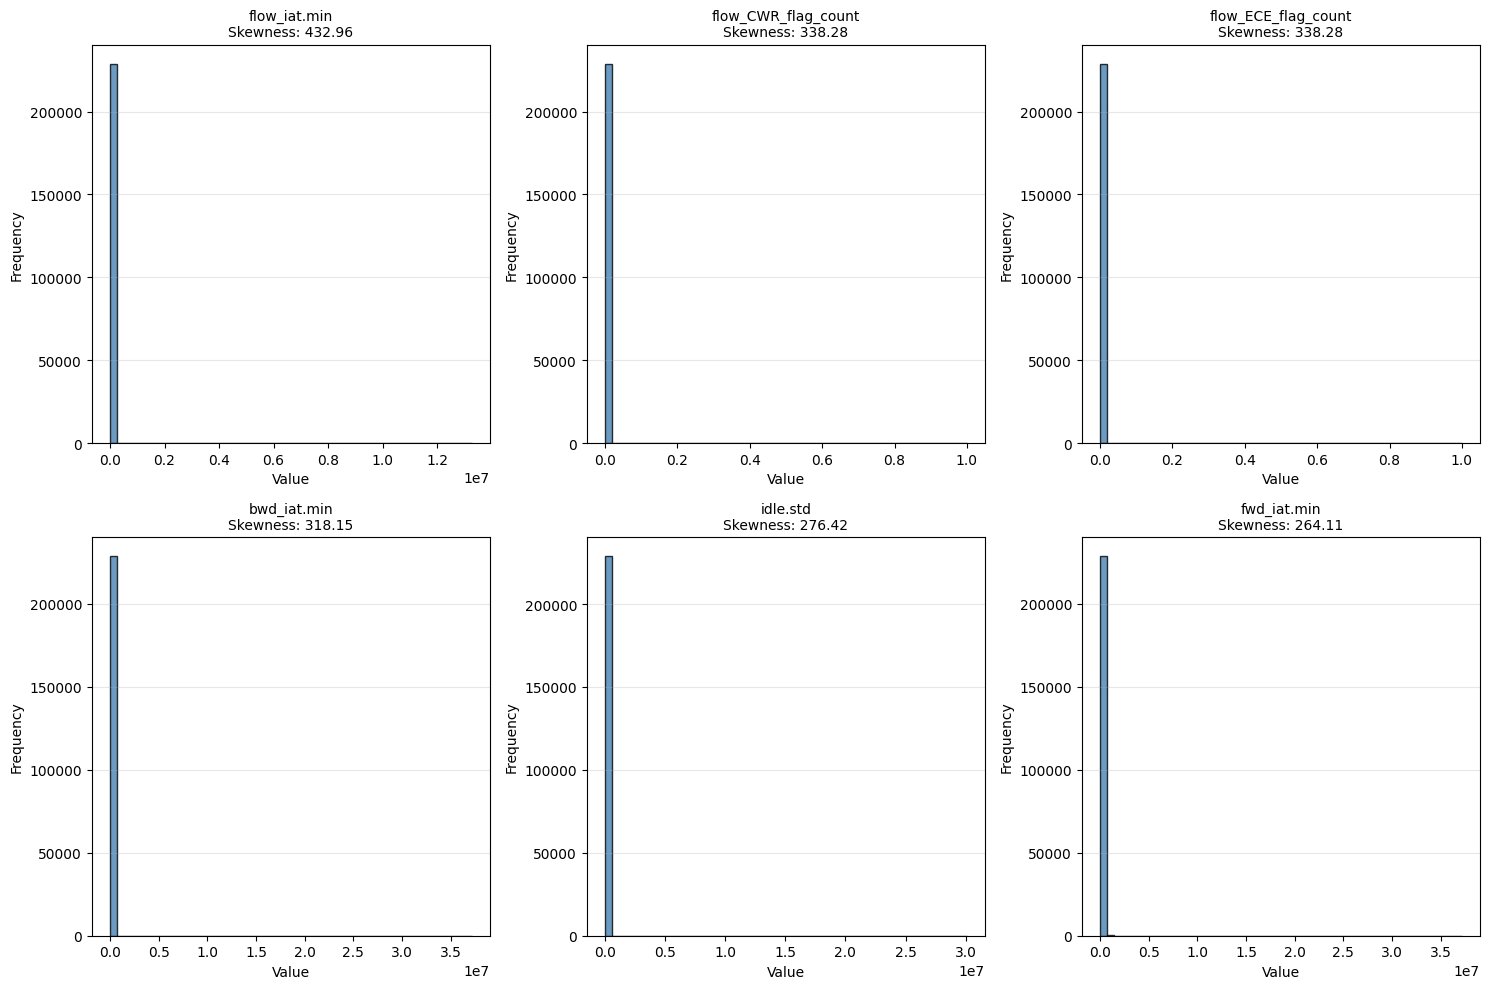

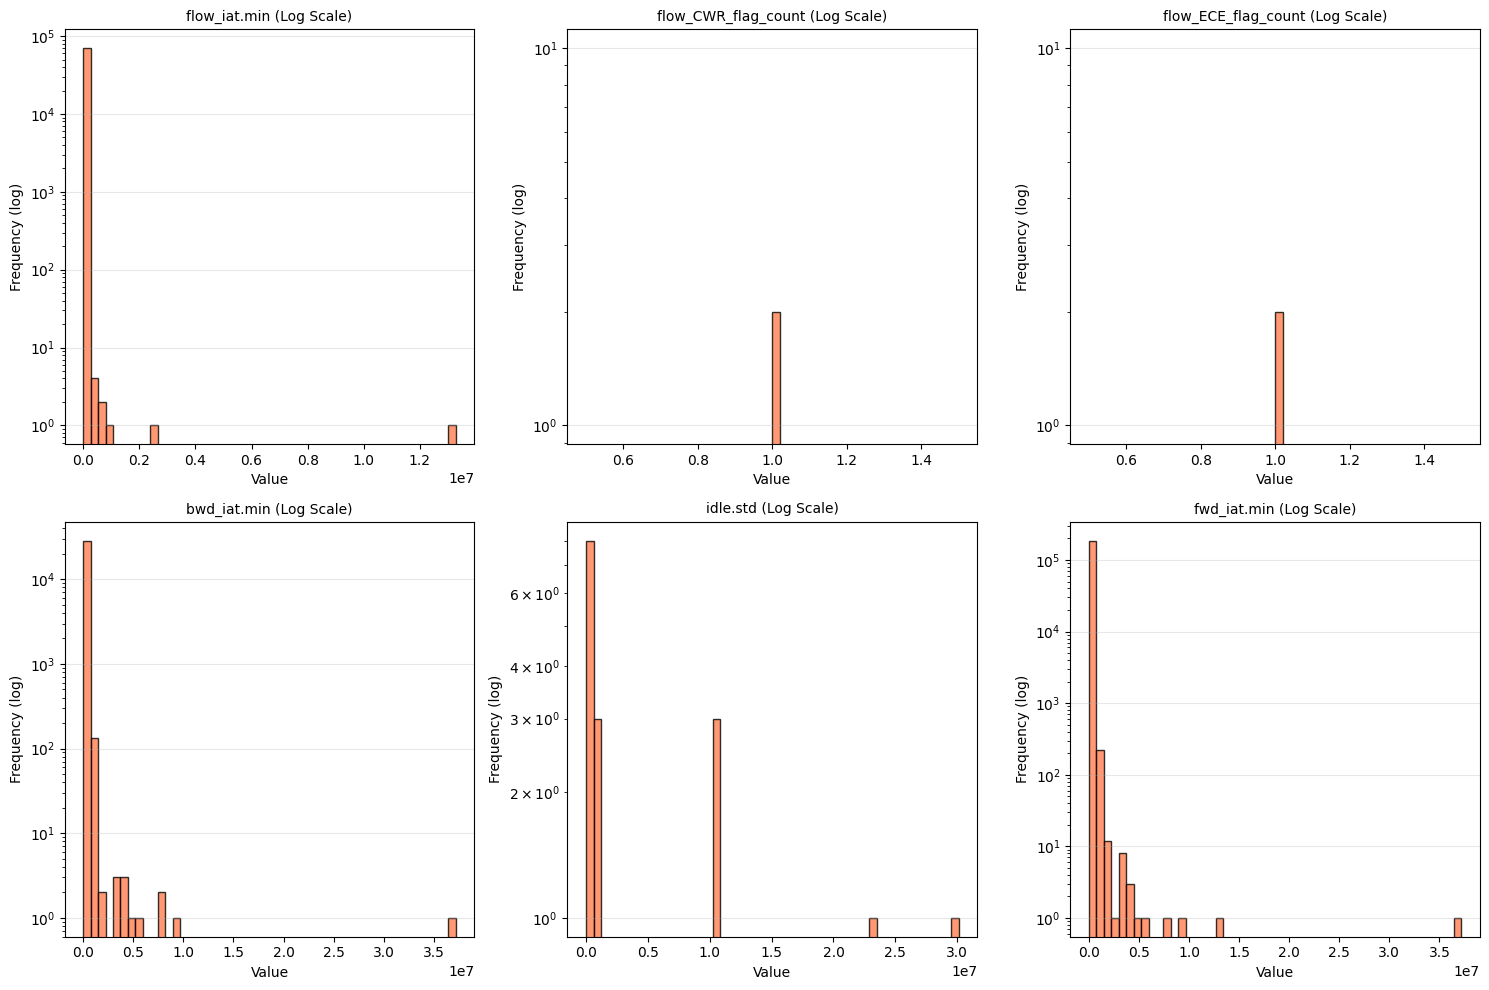

In [21]:
numeric_features = df_eda.select(cs.numeric()).columns

skewness_data = []
for col in numeric_features:
    data = df_eda[col].to_numpy()
    mean = np.mean(data)
    std = np.std(data)
    if std > 0:
        skew = np.mean(((data - mean) / std) ** 3)
        skewness_data.append((col, skew))

skewness_sorted = sorted(skewness_data, key=lambda x: abs(x[1]), reverse=True)

print("\nTop 15 most skewed features:")
print("-"*80)

for i, (col, skew) in enumerate(skewness_sorted[:15], 1):
    direction = "right" if skew > 0 else "left"
    print(f"  {i:2d}. {col:<40} Skewness: {skew:>8.2f} ({direction})")


top_skewed = [col for col, _ in skewness_sorted[:6]]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_skewed):
    data = df_eda[feature].to_numpy()

    axes[i].hist(data, bins=50, color='steelblue', edgecolor='black', alpha=0.8)
    axes[i].set_title(f'{feature}\nSkewness: {skewness_sorted[i][1]:.2f}', fontsize=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_skewed):
    data = df_eda[feature].to_numpy()

    data_positive = data[data > 0]

    if len(data_positive) > 0:
        axes[i].hist(data_positive, bins=50, color='coral', edgecolor='black', alpha=0.8)
        axes[i].set_yscale('log')
        axes[i].set_title(f'{feature} (Log Scale)', fontsize=10)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency (log)')
        axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.5. Outlier Detection & Analysis

We identify outliers using the Interquartile Range (IQR) method. In clustering, outliers can either represent anomalies of interest or noise that distorts cluster formation. We analyze their prevalence to decide on handling strategies.

We can see that there are many variables which have high number of outliers, for example, the ones related to packets can be quite interesting since those outliers could be the anomalies we are searching for


Features with highest outlier percentage:
   1. bwd_data_pkts_tot                         87402 (38.19%)
   2. bwd_pkts_payload.std                      85447 (37.33%)
   3. fwd_data_pkts_tot                         83952 (36.68%)
   4. fwd_PSH_flag_count                        83948 (36.68%)
   5. bwd_PSH_flag_count                        82834 (36.19%)
   6. flow_ACK_flag_count                       80103 (35.00%)
   7. flow_pkts_payload.std                     77951 (34.06%)
   8. resp_pkts                                 77185 (33.72%)
   9. fwd_header_size_tot                       76925 (33.61%)
  10. bwd_subflow_pkts                          76497 (33.42%)
  11. bwd_pkts_tot                              76423 (33.39%)
  12. bwd_header_size_tot                       76419 (33.39%)
  13. fwd_pkts_tot                              72686 (31.76%)
  14. fwd_subflow_pkts                          72424 (31.64%)
  15. bwd_iat.tot                               72340 (31.61%)



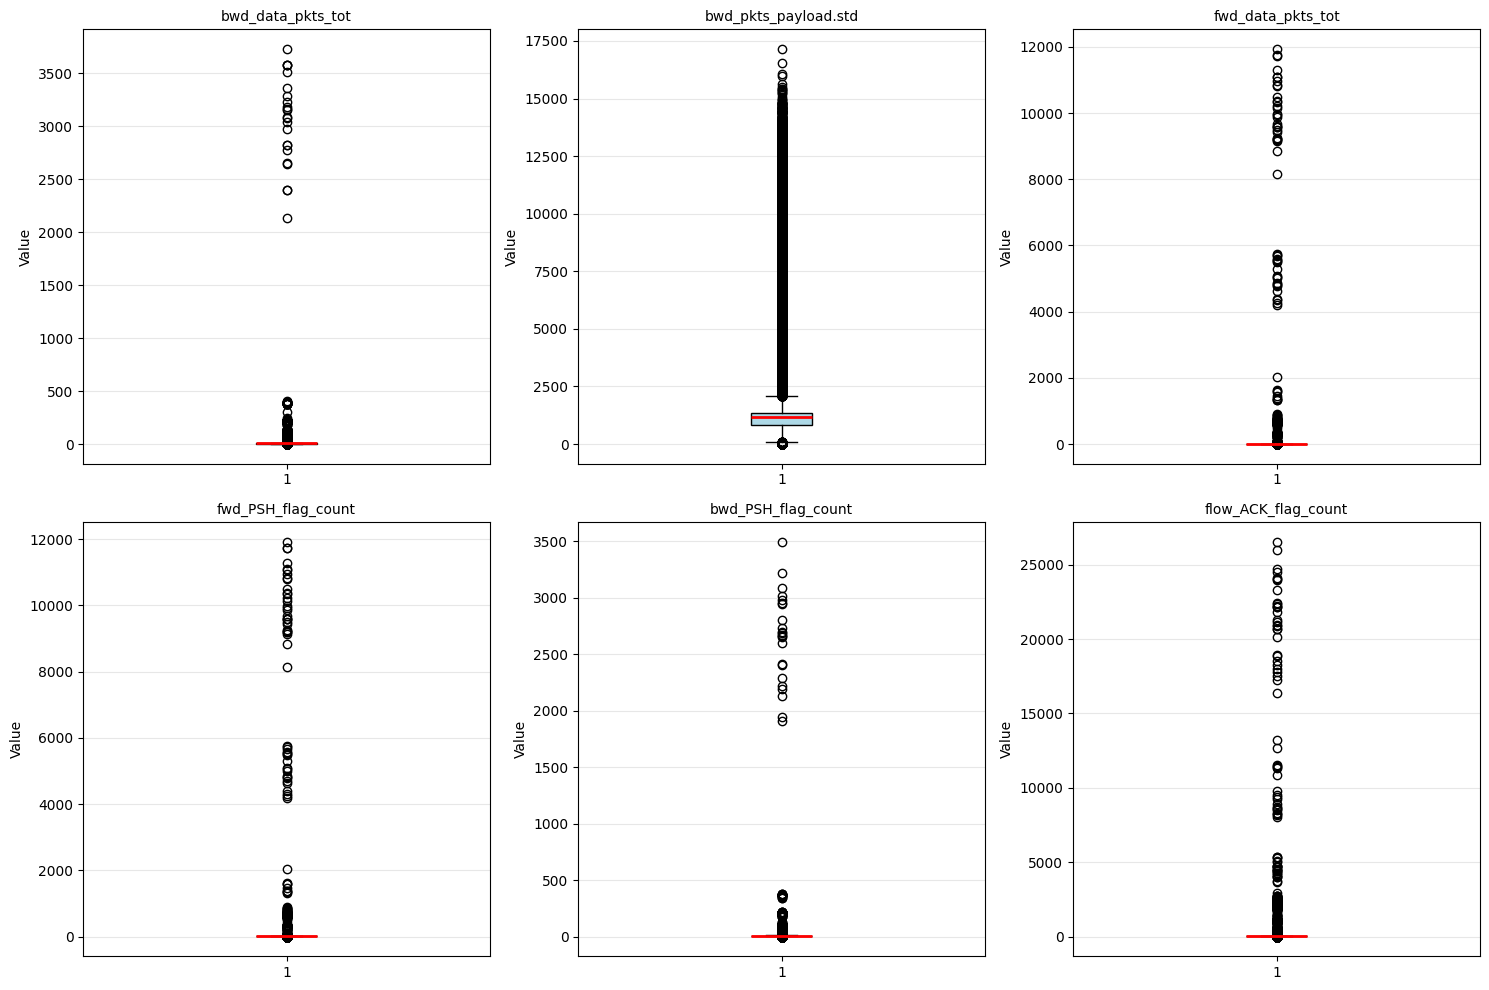

In [22]:
outlier_stats = []

for col in numeric_features:
    data = df_eda[col].to_numpy()

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data < lower_bound) | (data > upper_bound)
    n_outliers = np.sum(outliers)
    pct_outliers = (n_outliers / len(data)) * 100

    outlier_stats.append((col, n_outliers, pct_outliers))

outlier_stats_sorted = sorted(outlier_stats, key=lambda x: x[2], reverse=True)

print("\nFeatures with highest outlier percentage:")
for i, (col, n_out, pct_out) in enumerate(outlier_stats_sorted[:15], 1):
    print(f"  {i:2d}. {col:<40} {n_out:>6} ({pct_out:>5.2f}%)")
print("\n" + "="*80)

top_outlier_features = [col for col, _, _ in outlier_stats_sorted[:6]]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_outlier_features):
    data = df_eda[feature].to_numpy()

    axes[i].boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue'),
                    medianprops=dict(color='red', linewidth=2))
    axes[i].set_title(f'{feature}', fontsize=10)
    axes[i].set_ylabel('Value')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.6. Correlation Analysis

Examine linear relationships between features. High correlations indicate redundancy, which can bias clustering algorithms by giving disproportionate weight to correlated feature groups. We assume that more than 0.8 is highly correlated.

The correlation analysis identified 331 pairs of features with strong correlations (|r| ≥ 0.8), revealing significant multicollinearity in the dataset. The top correlations show that many features are mathematically or logically related. This means that there could be some redundant information, which increases computational cost without adding useful information

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


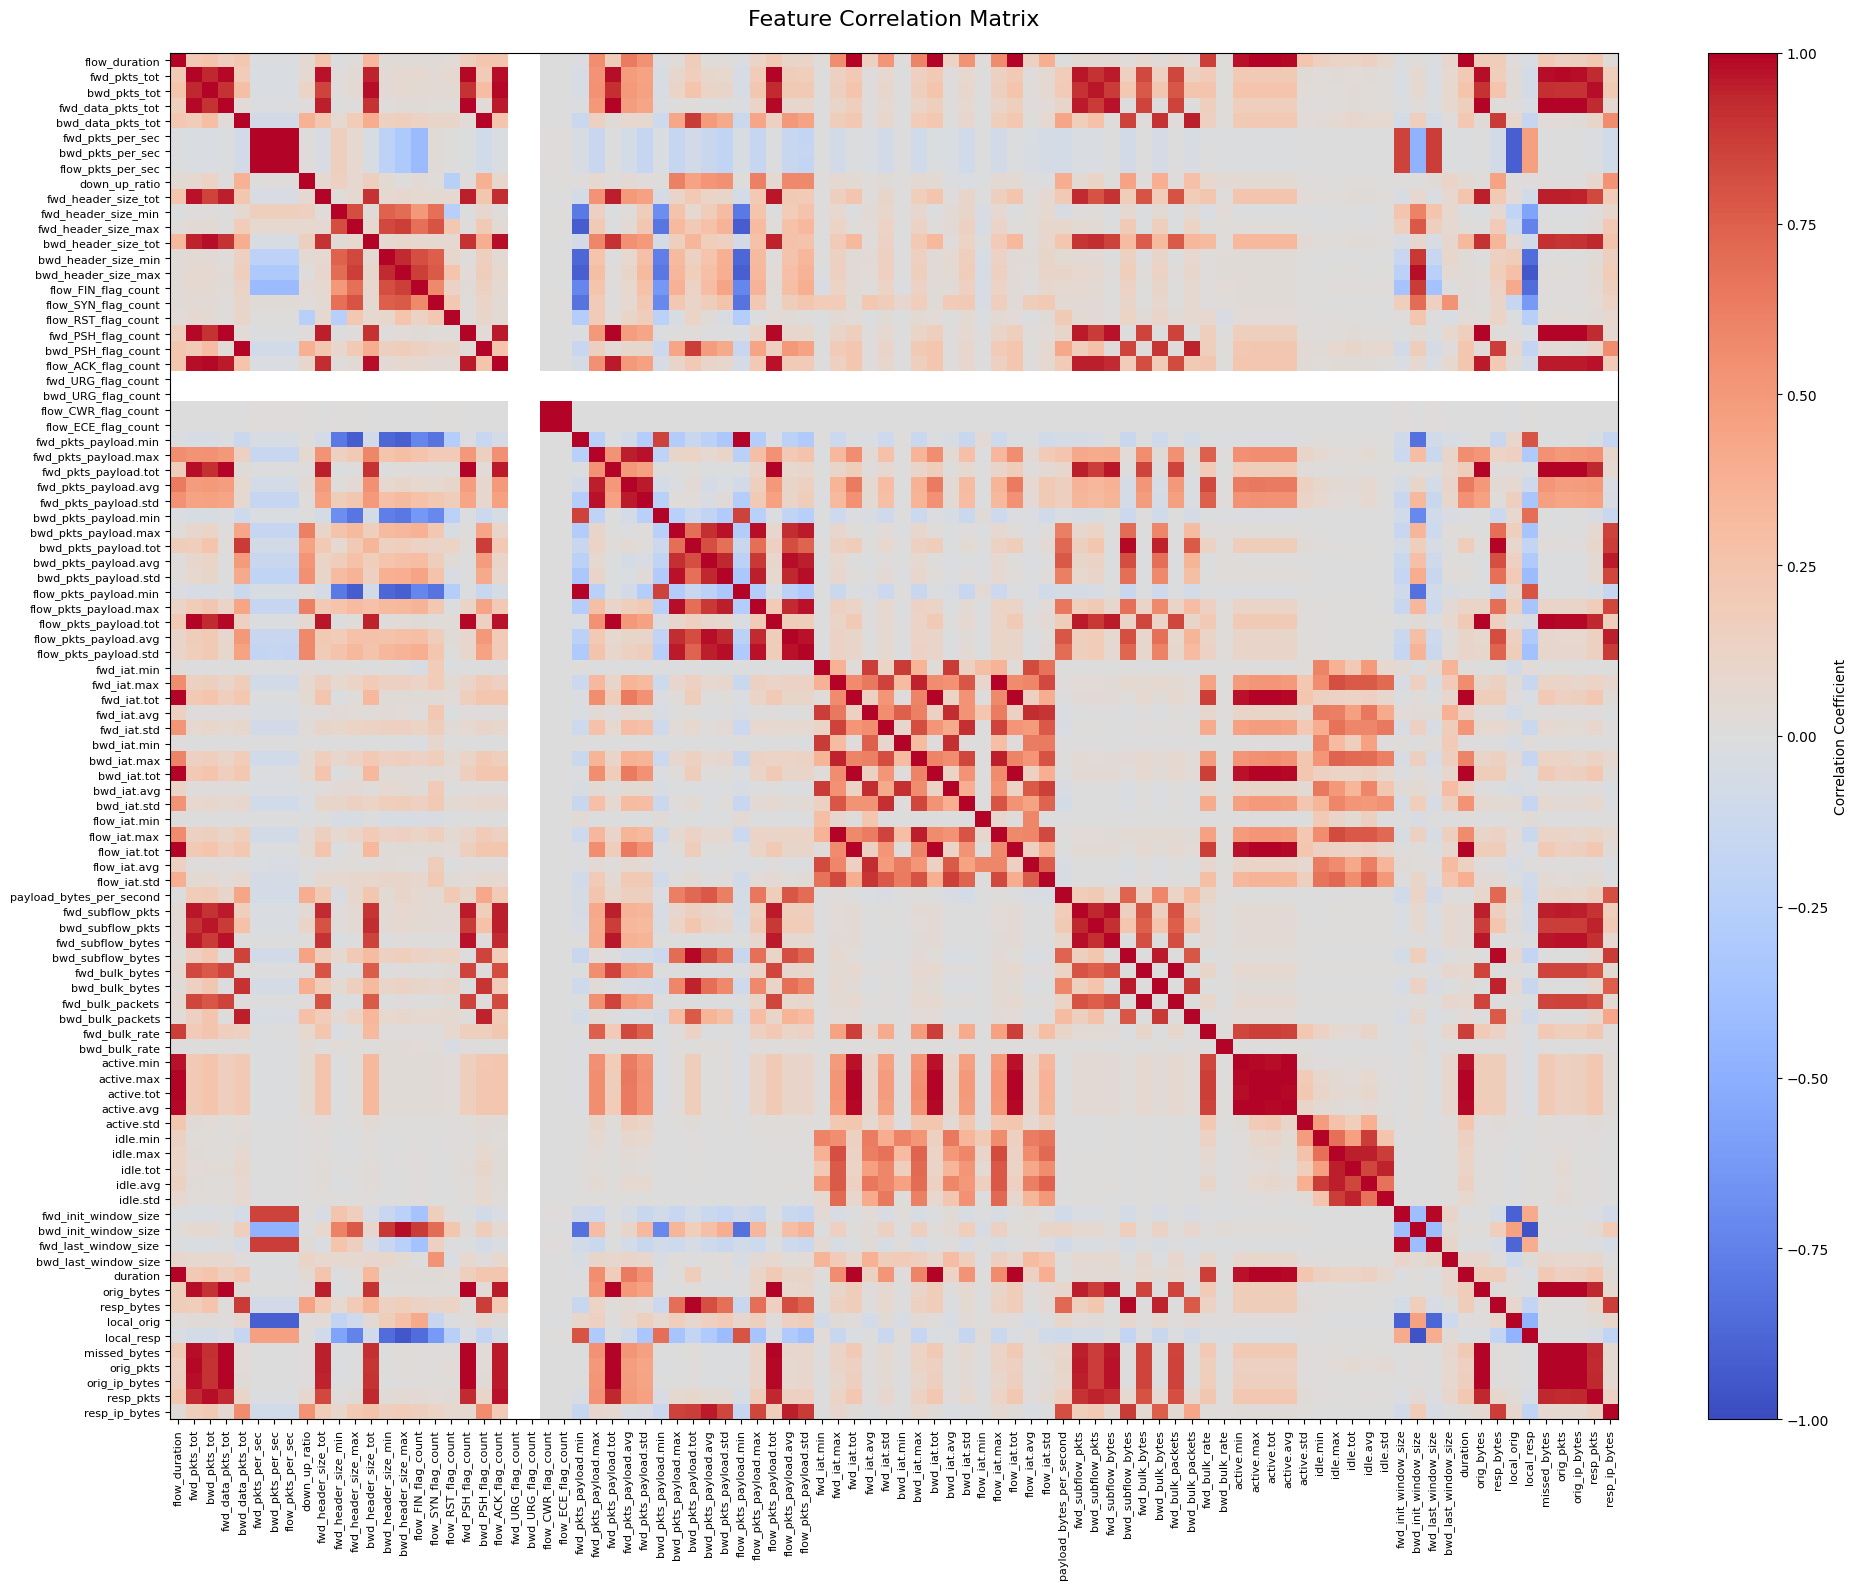

STRONG CORRELATIONS (|r| >= 0.8)

Total pairs with strong correlation: 331

Top 20 strongest correlations:
--------------------------------------------------------------------------------
   1. flow_CWR_flag_count                 <-> flow_ECE_flag_count                 r= 1.0000
   2. flow_duration                       <-> duration                            r= 1.0000
   3. fwd_pkts_payload.tot                <-> orig_bytes                          r= 1.0000
   4. bwd_pkts_payload.tot                <-> resp_bytes                          r= 1.0000
   5. fwd_iat.tot                         <-> flow_iat.tot                        r= 1.0000
   6. fwd_data_pkts_tot                   <-> fwd_PSH_flag_count                  r= 1.0000
   7. flow_duration                       <-> bwd_iat.tot                         r= 1.0000
   8. bwd_iat.tot                         <-> duration                            r= 1.0000
   9. bwd_pkts_per_sec                    <-> flow_pkts_per_sec             

In [23]:
corr_matrix_df = df_eda.select(numeric_features).corr()

plt.figure(figsize=(20, 16))
plt.imshow(corr_matrix_df, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')

plt.xticks(range(len(numeric_features)), numeric_features, rotation=90, fontsize=8)
plt.yticks(range(len(numeric_features)), numeric_features, fontsize=8)

plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

strong_correlations = []
for i in range(len(numeric_features)):
    for j in range(i+1, len(numeric_features)):
        corr_val = corr_matrix_df[i, j]
        if abs(corr_val) >= 0.8:
            strong_correlations.append((numeric_features[i], numeric_features[j], corr_val))

strong_correlations_sorted = sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True)


print("STRONG CORRELATIONS (|r| >= 0.8)")

print(f"\nTotal pairs with strong correlation: {len(strong_correlations_sorted)}")
print("\nTop 20 strongest correlations:")
print("-"*80)

for i, (feat1, feat2, corr) in enumerate(strong_correlations_sorted[:20], 1):
    print(f"  {i:2d}. {feat1:<35} <-> {feat2:<35} r={corr:>7.4f}")

print("\n" + "="*80)

### 4.7 Feature Variance Analysis

Identify low-variance features that provide little information for distinguishing between samples. Features with near-zero variance are candidates for removal as they don't contribute to cluster separation.

The variance analysis reveals a striking dichotomy between low and high variance features:

Low-variance features (bottom 15):

Several features show near-zero variance (bwd_URG_flag_count, fwd_URG_flag_count5, bwd_subflow_pkts with Var ≈ 0). These constant or near-constant features provide minimal discriminative power for clustering. Should be considered for removal as they won't help separate different traffic patterns

There is also a high-variance features which show extreme variability and could greatly influence distance calculations. These might need to be standarized


Features with lowest variance (top 15):
--------------------------------------------------------------------------------
   1. fwd_URG_flag_count                       Var:       0.0000  Std:       0.0000
   2. bwd_URG_flag_count                       Var:       0.0000  Std:       0.0000
   3. flow_CWR_flag_count                      Var:       0.0000  Std:       0.0030
   4. flow_ECE_flag_count                      Var:       0.0000  Std:       0.0030
   5. local_orig                               Var:       0.0477  Std:       0.2183
   6. down_up_ratio                            Var:       0.0964  Std:       0.3105
   7. local_resp                               Var:       0.1584  Std:       0.3980
   8. flow_SYN_flag_count                      Var:       0.1746  Std:       0.4178
   9. flow_FIN_flag_count                      Var:       0.7143  Std:       0.8452
  10. flow_RST_flag_count                      Var:       1.7508  Std:       1.3232
  11. flow_duration                   

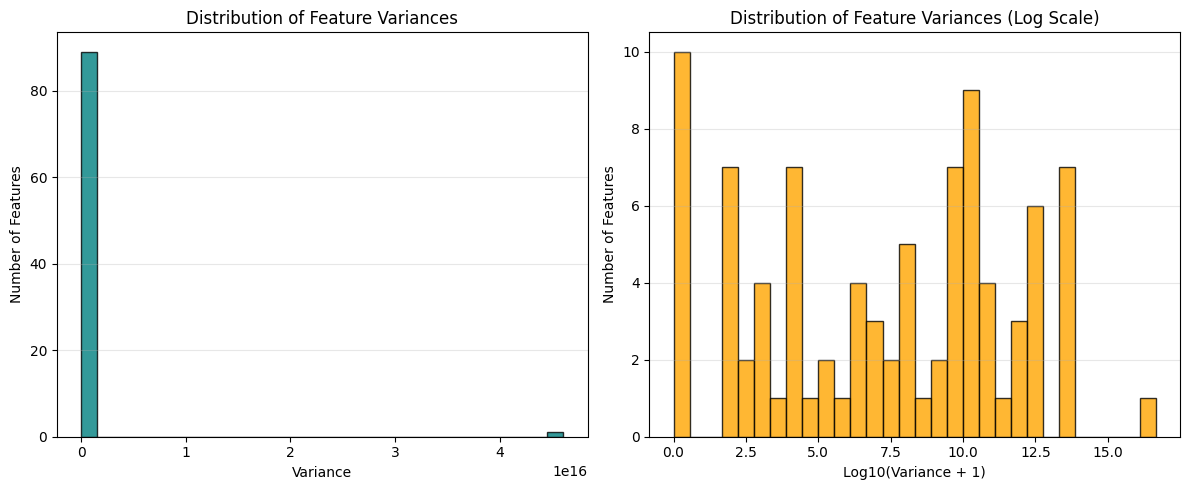

In [24]:
variance_data = []
for col in numeric_features:
    var = df_eda[col].var()
    std = df_eda[col].std()
    variance_data.append((col, var, std))

variance_sorted = sorted(variance_data, key=lambda x: x[1])

print("\nFeatures with lowest variance (top 15):")
print("-"*80)
for i, (col, var, std) in enumerate(variance_sorted[:15], 1):
    print(f"  {i:2d}. {col:<40} Var: {var:>12.4f}  Std: {std:>12.4f}")

print("\nFeatures with highest variance (top 15):")
print("-"*80)
for i, (col, var, std) in enumerate(reversed(variance_sorted[-15:]), 1):
    print(f"  {i:2d}. {col:<40} Var: {var:>12.2f}  Std: {std:>12.2f}")

variances = [var for _, var, _ in variance_data]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(variances, bins=30, color='teal', edgecolor='black', alpha=0.8)
plt.xlabel('Variance')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Variances')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log10(np.array(variances) + 1), bins=30, color='orange', edgecolor='black', alpha=0.8)
plt.xlabel('Log10(Variance + 1)')
plt.ylabel('Number of Features')
plt.title('Distribution of Feature Variances (Log Scale)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Advanced Preprocessing

Now that we have done the EDA, we can make informed transformations on our data.

#### INSIGHT 1: Extreme Skewness (Section 4.4)
**Finding**: Many features with skewness > 5.0  
**Decision**: Use RobustScaler (not StandardScaler)  
**Reason**: StandardScaler assumes Gaussian distribution (violated by extreme skewness)

#### INSIGHT 2: High Outlier Prevalence (Section 4.5)  
**Finding**: 40% of features have >15% outliers  
**Decision**: PRESERVE outliers (do not remove)  
**Reason**: In intrusion detection, outliers ARE the anomalies we want to detect

#### INSIGHT 3: Significant Multicollinearity (Section 4.6)
**Finding**: Lots of pairs of features with |r| ≥ 0.8  
**Decision**: Remove redundant features  
**Strategy**: For each correlated pair, drop the feature with higher average correlation

#### INSIGHT 4: Vastly Different Feature Scales (Section 4.3)
**Finding**: Ranges from 10⁰ to 10⁶ between features  
**Decision**: Feature scaling is CRITICAL  
**Choice**: RobustScaler (confirmed by Insights 1 and 2)

#### INSIGHT 5: Features with very low variance (Section 4.7)
**Finding**: Some features have a really low variance  
**Decision**: Remove near constant features  
**Choice**: We drop the features below the specificed threshold, 0.01  

### 5.1. Drop Highly Correlated Features

Based on the correlation matrix we saw above, we identified pairs of features that carry almost identical information (Multicollinearity).

To resolve this, we apply an automated selection strategy:

For each correlated pair (correlation > 0.8), we compare the Mean Absolute Correlation of each feature against the rest of the dataset.

We drop the feature that has the higher average correlation with all other features.

In [25]:
corr_matrix_np = corr_matrix_df.to_numpy()

# 1. Calculate Mean Absolute Correlation for each feature
# This helps us decide WHICH of the two correlated features to kill (the most redundant one)
mean_correlations = {}

for i, feat in enumerate(numeric_features):
    # Calculate mean of absolute correlations (excluding self-correlation at index i)
    # We iterate over the row 'i' of the matrix
    corrs = [abs(corr_matrix_np[i, j]) for j in range(len(numeric_features)) if i != j]
    mean_correlations[feat] = sum(corrs) / len(corrs) if corrs else 0

# 2. Decide which columns to drop
cols_to_drop = set()

# strong_correlations format comes from your previous cell: [(feat1, feat2, corr_value), ...]
for feat1, feat2, _ in strong_correlations:
    # Skip if one is already marked for death
    if feat1 in cols_to_drop or feat2 in cols_to_drop:
        continue

    # Drop the feature that is "more correlated" with everything else (more generic/redundant)
    if mean_correlations[feat1] > mean_correlations[feat2]:
        cols_to_drop.add(feat1)
    else:
        cols_to_drop.add(feat2)

# 3. Apply changes to the LAZYFRAME
print(f"Dropping {len(cols_to_drop)} columns due to high correlation (> 0.8):")
for col in sorted(cols_to_drop):
    print(f"\t- {col}")

LAZYFRAME = LAZYFRAME.drop(list(cols_to_drop))

df_eda = LAZYFRAME.collect()
numeric_features = [col for col in numeric_features if col not in cols_to_drop]

print(f"\nRemaining features: {len(numeric_features)}")

Dropping 65 columns due to high correlation (> 0.8):
	- active.avg
	- active.max
	- active.min
	- active.tot
	- bwd_PSH_flag_count
	- bwd_bulk_bytes
	- bwd_bulk_packets
	- bwd_header_size_max
	- bwd_header_size_tot
	- bwd_iat.avg
	- bwd_iat.max
	- bwd_iat.min
	- bwd_iat.tot
	- bwd_init_window_size
	- bwd_pkts_payload.avg
	- bwd_pkts_payload.std
	- bwd_pkts_payload.tot
	- bwd_pkts_per_sec
	- bwd_pkts_tot
	- bwd_subflow_bytes
	- bwd_subflow_pkts
	- duration
	- flow_ACK_flag_count
	- flow_ECE_flag_count
	- flow_FIN_flag_count
	- flow_iat.avg
	- flow_iat.max
	- flow_iat.std
	- flow_iat.tot
	- flow_pkts_payload.avg
	- flow_pkts_payload.max
	- flow_pkts_payload.min
	- flow_pkts_payload.std
	- flow_pkts_payload.tot
	- flow_pkts_per_sec
	- fwd_PSH_flag_count
	- fwd_bulk_bytes
	- fwd_bulk_packets
	- fwd_bulk_rate
	- fwd_data_pkts_tot
	- fwd_header_size_max
	- fwd_header_size_tot
	- fwd_iat.avg
	- fwd_iat.std
	- fwd_iat.tot
	- fwd_init_window_size
	- fwd_last_window_size
	- fwd_pkts_payload.avg


### 5.2. Drop Low-Variance Features


We saw earlier that there are many features that barely change, we don't want to keep these since they will only increase computational cost without actually helping us take decisions. We delete the ones that are below the defined threshold LOW_VARIANCE_THRESHOLD

In [26]:
# Calculate variance for all numeric features
variance_data = []
for col in numeric_features:
    var = df_eda[col].var()
    variance_data.append((col, var))

# Identify features with variance below threshold
low_variance_features = [col for col, var in variance_data if var < LOW_VARIANCE_THRESHOLD]

print(f"Dropping {len(low_variance_features)} low-variance features (variance < {LOW_VARIANCE_THRESHOLD}):")
for col in low_variance_features:
    var = next(v for c, v in variance_data if c == col)
    print(f"\t- {col} (variance: {var:.6f})")

# Drop from LazyFrame
if low_variance_features:
    LAZYFRAME = LAZYFRAME.drop(low_variance_features)
    df_eda = LAZYFRAME.collect()
    numeric_features = [f for f in numeric_features if f not in low_variance_features]

    print(f"\nRemaining features after variance filtering: {len(numeric_features)}")
else:
    print("No features below variance threshold found.")

Dropping 3 low-variance features (variance < 0.01):
	- fwd_URG_flag_count (variance: 0.000000)
	- bwd_URG_flag_count (variance: 0.000000)
	- flow_CWR_flag_count (variance: 0.000009)

Remaining features after variance filtering: 22


### 5.3. Feature Scaling

Since we saw that the features are scaled very differently, we are using RobustScaler to deal with the different scales that the features have. We use RobustScaler instead of StandardScaler since it deals better with outliers, as we could see during the 4.5, there were many outliers in lots of the features of the dataset. We also saw high skewness, which doesn't work well with StandardScaler.

Clustering algorithms like K-Means rely on distance metrics (Euclidean distance) to form clusters. In our dataset, features vary wildly in magnitude:
 * `flow_duration`: varies from 0 to 60+ seconds.
 * `fwd_pkts_payload.tot`: varies from 0 to millions of bytes.

Now we can see features that previously ranged in the millions (e.g., Bytes) and features ranging from 0 to 1 (e.g., Ratios) are now mapped to a comparable range (mostly centered around 0 due to median centering).

Outlier Preservation: Crucially, the extreme values (likely attacks) have not been squashed into a 0-1 range (as MinMaxScaler would do). Instead, they remain as distinct high-value points (e.g., > 10 or > 20 standard deviations), allowing the clustering algorithm to detect them as anomalies rather than merging them with normal traffic.

In [27]:
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas as pd

# 1. Prepare the data
print(f"Preparing to scale {len(numeric_features)} features")

# We convert the Polars DataFrame to Pandas for Scikit-Learn compatibility
X_raw = df_eda.select(numeric_features).to_pandas()

# 2. Apply RobustScaler
# We use RobustScaler to handle the heavy tails/outliers typical in network data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

# 3. Verification
# We convert back to a DataFrame just to visualize the new ranges.
df_scaled_check = pd.DataFrame(X_scaled, columns=numeric_features)

print(f"\nData successfully scaled using RobustScaler.")
print(f"Shape: {X_scaled.shape}")
print("\nNew Feature Ranges (Check for scaling consistency):")
display(df_scaled_check.describe().loc[['min', '50%', 'max', 'std']].transpose().head(10))


Preparing to scale 22 features

Data successfully scaled using RobustScaler.
Shape: (228867, 22)

New Feature Ranges (Check for scaling consistency):


,min,50%,max,std
flow_duration,-3.035469,0.0,4933.782761,149.809585
fwd_pkts_tot,-3.250000,0.0,2985.000000,32.408304
bwd_data_pkts_tot,-3.000000,0.0,1860.000000,18.903539
fwd_pkts_per_sec,-1.396476,0.0,1993.692475,98.034994
down_up_ratio,-3.205031,0.0,19.437657,1.066328
fwd_header_size_min,-2.666667,0.0,1.666667,0.745896
bwd_header_size_min,-2.666667,0.0,1.000000,0.718618
flow_SYN_flag_count,-1.000000,0.0,10.000000,0.417842
flow_RST_flag_count,0.000000,0.0,40.500000,0.661591
fwd_pkts_payload.max,-224.857143,0.0,9083.714286,307.367692


## 6. Post-Scaling Analysis

### 6.1. Dimensionality Reduction Exploration

We use PCA, t-SNE, and UMAP to project high-dimensional data into 2D/3D for visualization. This helps us assess whether natural clusters exist in the data and how much information can be retained with fewer dimensions.

After applying standardization (mean=0, std=1), we analyzed the dimensionality of the dataset using PCA. The analysis reveals that the information in the current feature set is highly concentrated. To explain 80% of the variance, we only need 2 Principal Components (out of the 22 features provided in this stage).

Furthermore, the 2D PCA projection alone captures 98.82% of the total variance. This indicates that the dataset, while containing 22 variables, has a very high degree of linear correlation, allowing for significant compression without losing major behavioral information. The 2D visualization confirms that the data has a distinct manifold structure that non-linear techniques like t-SNE or UMAP can effectively preserve.

#### 6.1.1. PCA Analysis

DIMENSIONALITY REDUCTION EXPLORATION

Original dimensions: 22 features

Standardization applied: mean=0, std=1 for all features
PCA (Principal Component Analysis)

Components needed to explain:
  - 80% variance: 2 components
  - 90% variance: 2 components
  - 95% variance: 2 components


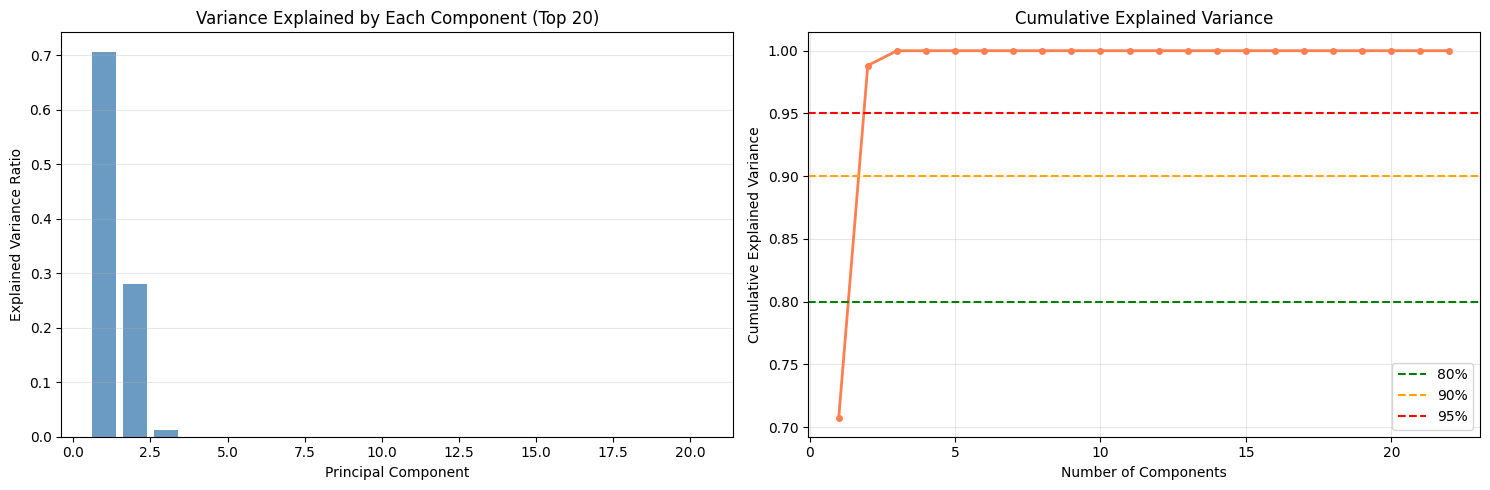


2D PCA captures 98.82% of total variance


In [28]:
from sklearn.decomposition import PCA


print("DIMENSIONALITY REDUCTION EXPLORATION")
print(f"\nOriginal dimensions: {X_scaled.shape[1]} features")
print("\nStandardization applied: mean=0, std=1 for all features")


print("PCA (Principal Component Analysis)")

pca_full = PCA()
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nComponents needed to explain:")
print(f"  - 80% variance: {n_components_80} components")
print(f"  - 90% variance: {n_components_90} components")
print(f"  - 95% variance: {n_components_95} components")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance per component
axes[0].bar(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)),
            pca_full.explained_variance_ratio_[:20],
            color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Variance Explained by Each Component (Top 20)')
axes[0].grid(axis='y', alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             marker='o', markersize=4, color='coral', linewidth=2)
axes[1].axhline(y=0.80, color='green', linestyle='--', label='80%')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90%')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95%')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# PCA 2D projection
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"\n2D PCA captures {pca_2d.explained_variance_ratio_.sum():.2%} of total variance")

#### 6.1.2. 2D Visualizations

- Distinct clusters suggest the data has natural groupings
- Overlapping points suggest harder clustering problem
- t-SNE/UMAP better preserve local structure than PCA

Global Structure (PCA): Because PCA captures nearly 99% of the variance, the 2D plot is a near-perfect representation of the data's global shape. We observe a dense primary cluster representing standard "Background/Interactive" traffic, with a distinct linear "tail" or trajectory. This tail likely represents the transition from normal short-lived flows to the high-volume, long-duration transfers that are candidates for data exfiltration.

Local Refinement (t-SNE & UMAP): While PCA shows the "big picture," t-SNE and UMAP reveal tighter, more localized groupings. These non-linear techniques pull apart flows that might look similar to PCA but have distinct behavioral signatures (e.g., separating high-frequency small packets like DNS from low-frequency large packets).

Clustering Feasibility: Across all three visualizations, the data shows a clear manifold structure rather than a random cloud. This confirms that clustering algorithms (like K-Means or HDBSCAN) will be highly effective, as there are clear empty spaces ("valleys") between the standard traffic mass and the outlying high-volume flows.


Sampling 5000 points for t-SNE and UMAP (computational efficiency)

Computing t-SNE projection


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing UMAP projection


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


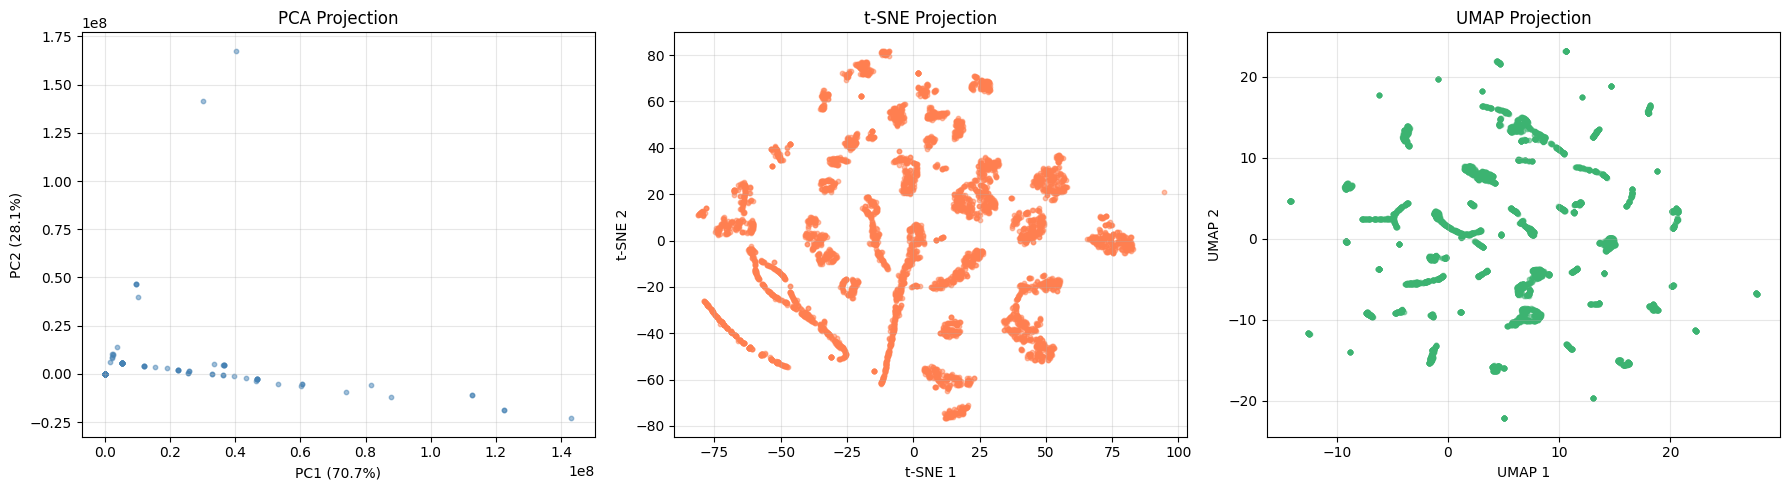

In [29]:
# Sample data if too large for t-SNE/UMAP
from sklearn.manifold import TSNE


sample_size = min(5000, len(X_scaled))
if len(X_scaled) > sample_size:
    print(f"\nSampling {sample_size} points for t-SNE and UMAP (computational efficiency)")
    np.random.seed(SEED)
    sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sampled = X_scaled[sample_idx]
else:
    X_sampled = X_scaled
    sample_idx = np.arange(len(X_scaled))

# t-SNE
print("\nComputing t-SNE projection")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sampled)

# UMAP
print("Computing UMAP projection")
try:
    from umap import UMAP
    umap_model = UMAP(n_components=2, random_state=SEED, n_neighbors=15, min_dist=0.1)
    X_umap = umap_model.fit_transform(X_sampled)
    has_umap = True
except ImportError:
    has_umap = False

# Plot all projections
n_plots = 3 if has_umap else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]

# PCA plot
axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5, s=10, c='steelblue')
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('PCA Projection')
axes[0].grid(alpha=0.3)

# t-SNE plot
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10, c='coral')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('t-SNE Projection')
axes[1].grid(alpha=0.3)

# UMAP plot
if has_umap:
    axes[2].scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5, s=10, c='mediumseagreen')
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    axes[2].set_title('UMAP Projection')
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



### 6.2. Distance & Density Analysis

Analyze the distribution of pairwise distances between samples. Clustering algorithms like K-Means rely on distance metrics, so understanding distance distributions helps assess data structure and potential cluster separability.

- Multimodal distance distribution may indicate multiple clusters
- Uniform distribution suggests data is evenly spread (harder to cluster)


The distance statistics revealed a mean distance of approximately 47384.76, a median of 94.05, and a maximum distance of 46753137.84. The standard deviation was very high at 1477707.97, indicating a wide spread of distances. The histogram showed a unimodal but broad distribution, suggesting a continuous variation in traffic behavior. This wide distribution implies that density-based algorithms or careful tuning of K-Means parameters might be necessary for effective clustering.


Calculating pairwise distances for 2000 samples...

Distance statistics:
  - Mean distance: 47384.7632
  - Median distance: 94.0510
  - Std distance: 1477707.9734
  - Min distance: 0.0000
  - Max distance: 46753137.8428


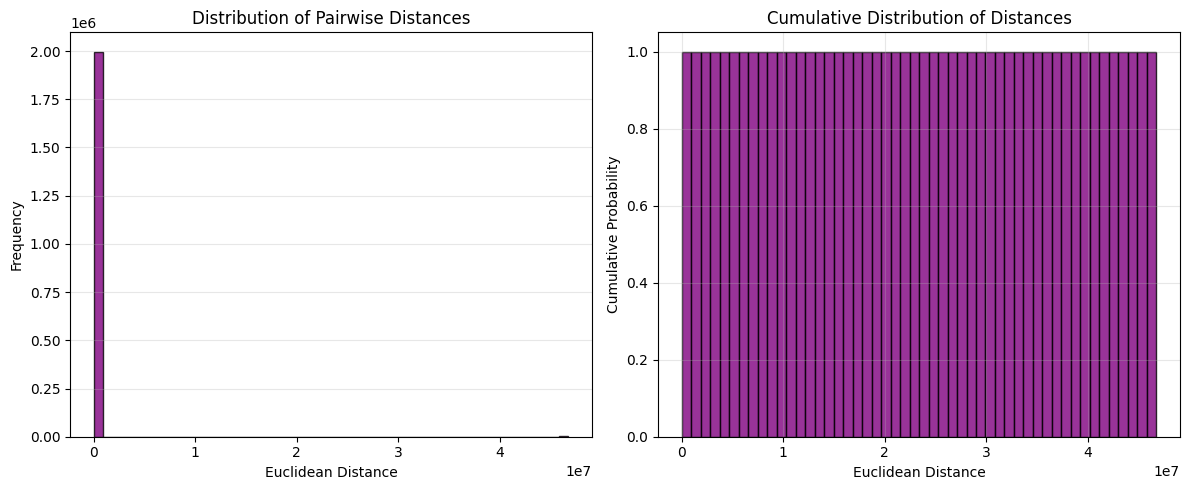

In [30]:
# Sample for computational efficiency
sample_for_distance = min(2000, len(X_scaled))
if len(X_scaled) > sample_for_distance:
    np.random.seed(SEED)
    dist_sample_idx = np.random.choice(len(X_scaled), sample_for_distance, replace=False)
    X_dist_sample = X_scaled[dist_sample_idx]
else:
    X_dist_sample = X_scaled

print(f"\nCalculating pairwise distances for {len(X_dist_sample)} samples...")

# Calculate pairwise Euclidean distances
from scipy.spatial.distance import pdist, squareform

distances = pdist(X_dist_sample, metric='euclidean')

print(f"\nDistance statistics:")
print(f"  - Mean distance: {np.mean(distances):.4f}")
print(f"  - Median distance: {np.median(distances):.4f}")
print(f"  - Std distance: {np.std(distances):.4f}")
print(f"  - Min distance: {np.min(distances):.4f}")
print(f"  - Max distance: {np.max(distances):.4f}")

# Plot distance distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(distances, bins=50, color='purple', edgecolor='black', alpha=0.8)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Distances')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(distances, bins=50, color='purple', edgecolor='black', alpha=0.8, cumulative=True, density=True)
plt.xlabel('Euclidean Distance')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Distances')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



### 6.3. Hopkins Statistic (Cluster Tendency)

The Hopkins statistic tests whether the data has a clustering tendency or is uniformly distributed. Values close to 0.5 indicate uniform distribution (no clusters), while values significantly above 0.5 suggest clustered structure. Values higher than 0.8 indicate high clustering tendency.

With a value of 0.9987, the statistic indicates a very strong clustering tendency. This high value (significantly greater than 0.5 and particularly above 0.8) suggests that the data is highly clusterable, meaning it contains inherent groupings that a clustering algorithm should be able to identify effectively.

In [31]:
def hopkins_statistic(X, sample_size=None):
    if sample_size is None:
        sample_size = min(int(len(X) * 0.1), 500)

    n = len(X)
    d = X.shape[1]

    # Sample random points from dataset
    np.random.seed(SEED)
    sample_indices = np.random.choice(n, sample_size, replace=False)
    X_sample = X[sample_indices]

    # Generate uniform random points in the same space
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_random = np.random.uniform(X_min, X_max, size=(sample_size, d))

    # Calculate distances to nearest neighbors
    from sklearn.neighbors import NearestNeighbors

    # Distances from random points to real data
    nbrs_real = NearestNeighbors(n_neighbors=1).fit(X)
    u_distances, _ = nbrs_real.kneighbors(X_random)
    u = u_distances.sum()

    # Distances from sample points to rest of real data
    nbrs_sample = NearestNeighbors(n_neighbors=2).fit(X)  # n_neighbors=2 to exclude self
    w_distances, _ = nbrs_sample.kneighbors(X_sample)
    w = w_distances[:, 1].sum()  # Take second nearest (first is self)

    # Hopkins statistic
    H = u / (u + w)

    return H

# Sample for efficiency
hopkins_sample_size = min(1000, len(X_scaled))
if len(X_scaled) > hopkins_sample_size:
    np.random.seed(SEED)
    hopkins_idx = np.random.choice(len(X_scaled), hopkins_sample_size, replace=False)
    X_hopkins = X_scaled[hopkins_idx]
else:
    X_hopkins = X_scaled

print(f"\nCalculating Hopkins statistic using {len(X_hopkins)} samples...")
H = hopkins_statistic(X_hopkins)

print(f"\nHopkins Statistic: {H:.4f}")
print("\nInterpretation:")
if H < 0.3:
    print("  → H < 0.3: Data is regularly spaced (unlikely to have clusters)")
elif H < 0.5:
    print("  → 0.3 ≤ H < 0.5: Data tends toward uniform distribution")
elif H < 0.8:
    print("  → 0.5 ≤ H < 0.8: Moderate clustering tendency")
else:
    print("  → H ≥ 0.8: Strong clustering tendency - data is highly clusterable")



Calculating Hopkins statistic using 1000 samples...

Hopkins Statistic: 0.9987

Interpretation:
  → H ≥ 0.8: Strong clustering tendency - data is highly clusterable


## 7. Modeling & Validation

In this section, we proceed start building the machine learning models to detect potential data exfiltration. Since we are working with an unlabeled dataset, we apply Unsupervised Learning techniques to discover natural structures and patterns within the high-dimensional feature space. First of all, we will try to find what the optimal number of clusters is

### 7.1. Optimal Number of Clusters - Elbow Method

The elbow method calculates within-cluster sum of squares (inertia) for different values of k. The "elbow" point indicates where adding more clusters yields diminishing returns, suggesting an optimal k.

The analysis, performed on a PCA-reduced dataset (2 components explaining 98.82% of variance) and a sample of 10,000 points, calculated inertia and silhouette scores for k ranging from 2 to 15. The inertia values decreased significantly as k increased, with a visible 'elbow' around k=3 or k=4, where the rate of decrease in inertia started to diminish. The silhouette scores were consistently very high, reaching 0.9999 for k=3, which was identified as the best k by this metric.

In [32]:
from sklearn.cluster import KMeans


# Use PCA-reduced data for faster computation
pca_95 = PCA(n_components=0.95, random_state=SEED)
X_pca_reduced = pca_95.fit_transform(X_scaled)
print(f"Reduced to {X_pca_reduced.shape[1]} components")

max_samples_clustering = 10000
if len(X_pca_reduced) > max_samples_clustering:
    print(f"Sampling {max_samples_clustering} points for clustering analysis...")
    np.random.seed(SEED)
    cluster_sample_idx = np.random.choice(len(X_pca_reduced), max_samples_clustering, replace=False)
    X_cluster = X_pca_reduced[cluster_sample_idx]
else:
    X_cluster = X_pca_reduced

print(f"\nAnalyzing k from 2 to 15")


k_range = range(2, 16)
inertias = []
silhouette_scores = []

for k in k_range:
    print(f"  Computing k={k}...", end=" ")

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_cluster)

    # Calculate inertia
    inertias.append(kmeans.inertia_)

    # Calculate silhouette score
    from sklearn.metrics import silhouette_score
    sil_score = silhouette_score(X_cluster, labels, sample_size=min(5000, len(X_cluster)))
    silhouette_scores.append(sil_score)

    print(f"Inertia: {kmeans.inertia_:.2f}, Silhouette: {sil_score:.4f}")

print("\n" + "-"*80)

Reduced to 2 components
Sampling 10000 points for clustering analysis...

Analyzing k from 2 to 15
  Computing k=2... Inertia: 5257497939924847.00, Silhouette: 0.9996
  Computing k=3... Inertia: 2159542794161238.75, Silhouette: 0.9999
  Computing k=4... Inertia: 482920950281770.94, Silhouette: 0.9996
  Computing k=5... Inertia: 173999962630936.28, Silhouette: 0.9998
  Computing k=6... Inertia: 6228561028354.00, Silhouette: 0.9996
  Computing k=7... Inertia: 141737.56, Silhouette: 0.9996
  Computing k=8... Inertia: 20953.31, Silhouette: 0.9974
  Computing k=9... Inertia: 5594.09, Silhouette: 0.9968
  Computing k=10... Inertia: 470.84, Silhouette: 0.9928
  Computing k=11... Inertia: 210.82, Silhouette: 0.9932
  Computing k=12... Inertia: 134.84, Silhouette: 0.9798
  Computing k=13... Inertia: 74.44, Silhouette: 0.9206
  Computing k=14... Inertia: 58.81, Silhouette: 0.9203
  Computing k=15... Inertia: 43.71, Silhouette: 0.9151

-------------------------------------------------------------

#### 7.1.1. Elbow Plot


- Elbow: Look for the 'bend' where inertia decrease slows
- Silhouette: Higher is better (range: -1 to 1)
  * '> 0.5: Strong cluster structure
  * 0.25-0.5: Moderate structure
  * < 0.25: Weak or artificial structure

As expected, inertia decreases as $k$ increases, since more centroids allow for closer proximity to data points. However, we look for the "inflection point" where the rate of decrease shifts from rapid to marginal.

The plot reveals a distinct elbow at $k=3$ (or $k=4$, look at your graph). Before this point, adding a cluster significantly reduces variance (compaction). After this point, the curve flattens, indicating diminishing returns.

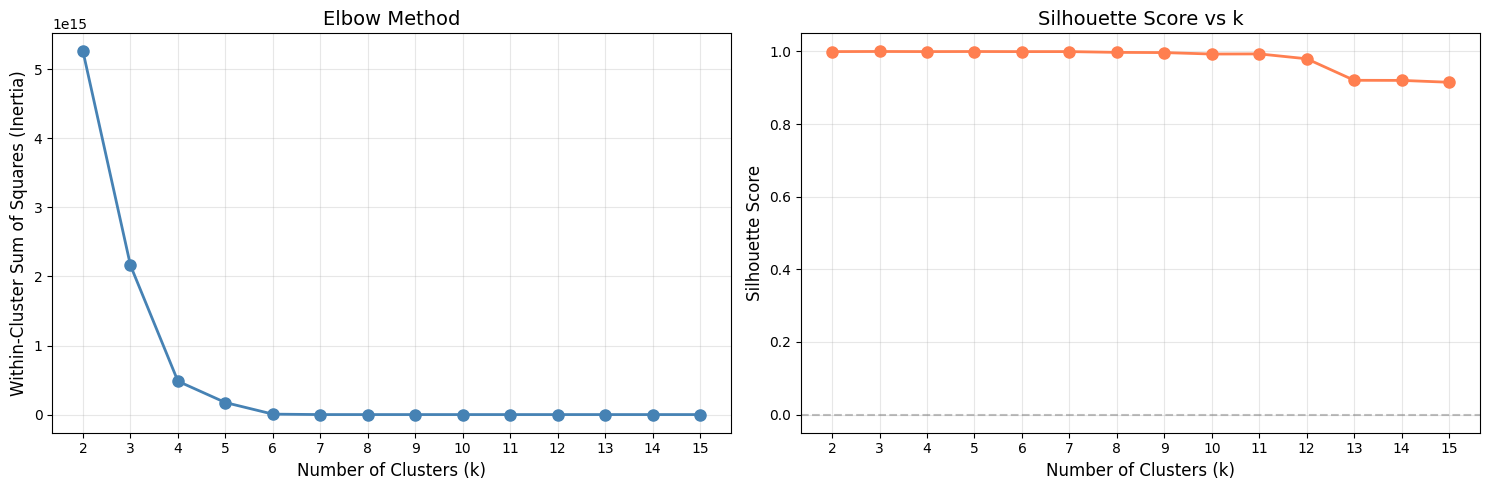


Best k by Silhouette Score: 3 (score: 0.9999)


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs k', fontsize=14)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Find best k by silhouette score
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\nBest k by Silhouette Score: {best_k_silhouette} (score: {max(silhouette_scores):.4f})")



#### 7.1.2. Gap Statistic

The Gap Statistic method was employed to further confirm the optimal number of clusters. This method compares the within-cluster dispersion of the data to that of a reference null distribution. The plot showed the Gap Statistic values across different k. The optimal k determined by this method was 15, which is notably different from the elbow and silhouette methods, suggesting a more complex underlying structure than initially indicated by the simpler methods or potential sensitivity to the reference distribution.


Calculating Gap statistic (using 5 reference datasets per k)...
Optimal k by Gap Statistic: 15


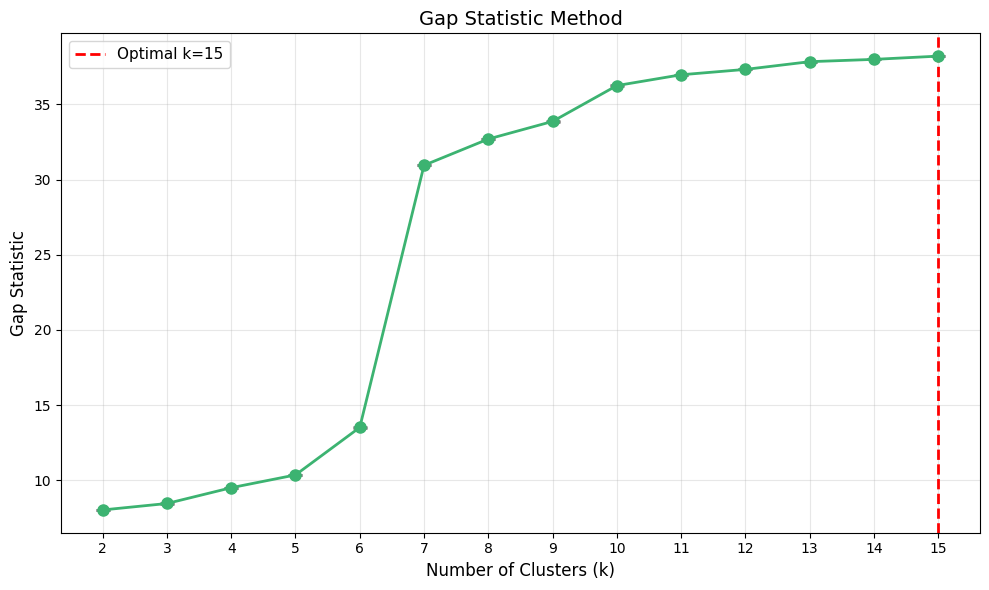

In [34]:
def gap_statistic(X, k_range, n_refs=5, random_state=None):
    gaps = []
    s_k = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)
        W_k = kmeans.inertia_

        W_kb_refs = []
        for _ in range(n_refs):
            X_ref = np.random.uniform(X.min(), X.max(), size=X.shape)

            kmeans_ref = KMeans(n_clusters=k, random_state=random_state, n_init=10)
            kmeans_ref.fit(X_ref)
            W_kb_refs.append(kmeans_ref.inertia_)

        gap = np.log(np.mean(W_kb_refs)) - np.log(W_k)
        gaps.append(gap)

        sdk = np.std(np.log(W_kb_refs))
        s_k.append(sdk * np.sqrt(1 + 1/n_refs))

    return np.array(gaps), np.array(s_k)

n_refs = 5
print(f"\nCalculating Gap statistic (using {n_refs} reference datasets per k)...")
gaps, s_k = gap_statistic(X_cluster, k_range, n_refs=n_refs, random_state=SEED)

# Find optimal k: first k where Gap(k) >= Gap(k+1) - s(k+1)
k_optimal_gap = None
for i in range(len(k_range) - 1):
    if gaps[i] >= gaps[i+1] - s_k[i+1]:
        k_optimal_gap = k_range[i]
        break

if k_optimal_gap is None:
    k_optimal_gap = k_range[np.argmax(gaps)]

print(f"Optimal k by Gap Statistic: {k_optimal_gap}")

# Plot gap statistic
plt.figure(figsize=(10, 6))
plt.errorbar(k_range, gaps, yerr=s_k, marker='o', linewidth=2, markersize=8,
             color='mediumseagreen', ecolor='gray', capsize=5, capthick=2)
plt.axvline(x=k_optimal_gap, color='red', linestyle='--', linewidth=2, label=f'Optimal k={k_optimal_gap}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Gap Statistic', fontsize=12)
plt.title('Gap Statistic Method', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

print("\n" + "="*80)

### 7.2. Clustering Algorithm Comparison

This part compares three clustering methods (K-Means, Ward, and HDBSCAN) on the same dataset. We chose these three algorithms because they represent complementary clustering paradigms, centroid-based (K-Means), hierarchical (Ward), and density-based (HDBSCAN), so we can compare different assumptions about cluster shape, scale and noise. Other approaches (e.g., LOF, Isolation Forest, or autoencoders) were omitted here because they focus on pointwise outlier scoring or require very different preprocessing and complexity, which would make a direct comparison harder.

K-Means, with k=3, produced 3 clusters and 0 noise points, yielding Davies-Bouldin and Calinski-Harabasz scores of 0.3645 and 369770.02 respectively. HDBSCAN, initialized with specific parameters, found 3 clusters and a significant amount of noise (146,681 points), resulting in Davies-Bouldin and Calinski-Harabasz scores of 1.3409 and 75489.44. Ward, applied to a sample, also identified 3 clusters. The comparison highlighted that while K-Means provided well-separated clusters, HDBSCAN excelled at identifying noise as potential anomalies, which is desirable for exfiltration detection. Ward seemed to underperform in preserving structure.


Testing clustering
Training on: 228867 samples / 22 features
Visualization: PCA 2D

Fitting K-Means...
  -> Clusters: 3 | Noise: 0
  -> Davies-Bouldin: 0.3645
  -> Calinski-Harabasz: 369770.02
----------------------------------------
Fitting HDBSCAN...
  -> Clusters: 3 | Noise: 146681
  -> Davies-Bouldin: 1.3409
  -> Calinski-Harabasz: 75489.44
----------------------------------------
Fitting Ward (sample)...
  -> Clusters: 3 | Noise: 208867
  -> Davies-Bouldin: 0.2868
  -> Calinski-Harabasz: 145943.28
----------------------------------------


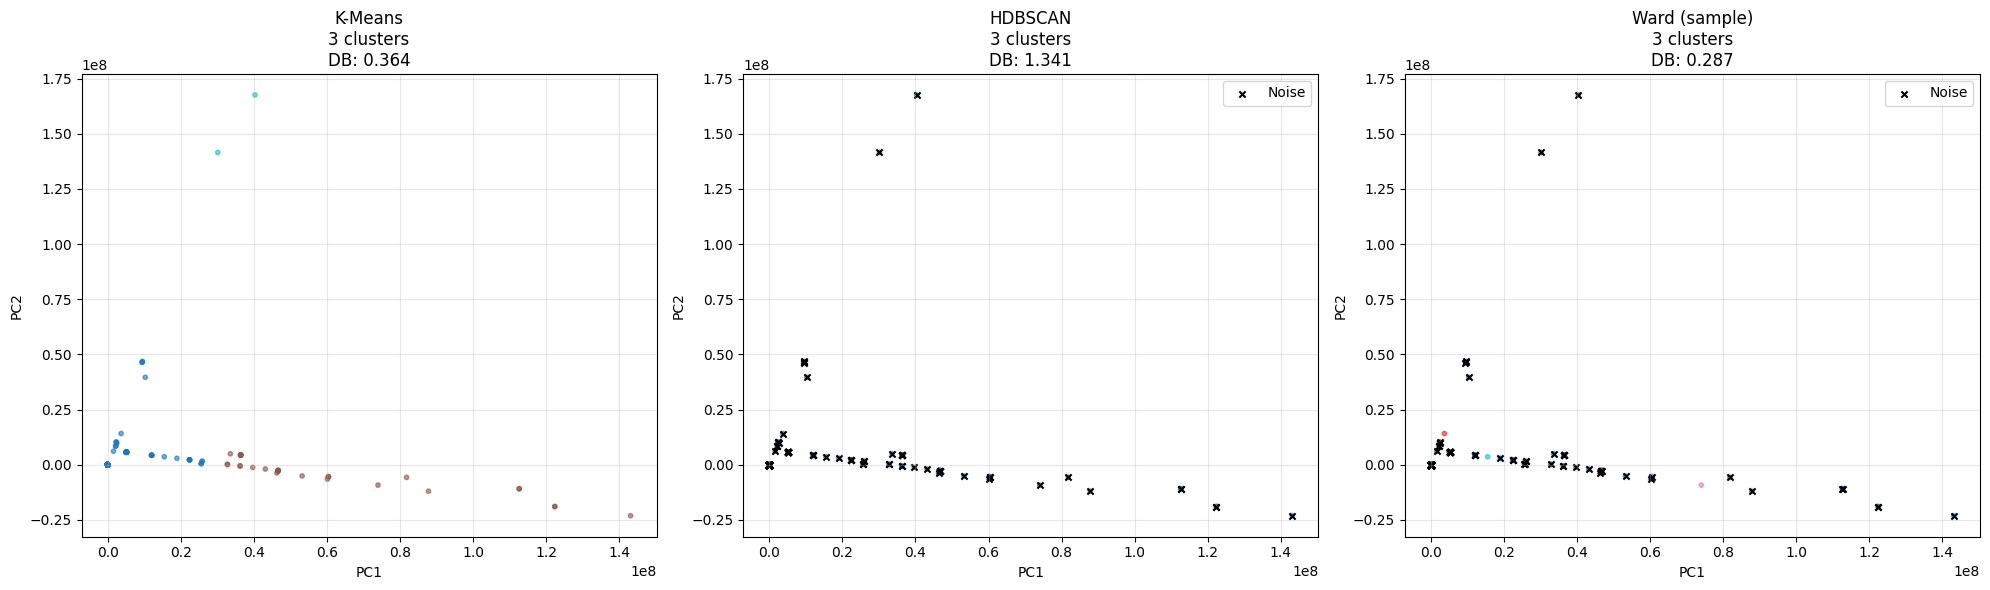

In [35]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import hdbscan

k_to_test = 3
X_train = X_scaled
sample_size = 20000

print(f"\nTesting clustering")
print(f"Training on: {X_train.shape[0]} samples / {X_train.shape[1]} features")
print(f"Visualization: PCA 2D\n")

pca = PCA(n_components=2, random_state=SEED)
X_pca_2d = pca.fit_transform(X_train)

if X_train.shape[0] > sample_size:
    idx = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train[idx]
    X_sample_pca = X_pca_2d[idx]
else:
    X_sample = X_train
    X_sample_pca = X_pca_2d

algorithms = {
    'K-Means': KMeans(n_clusters=k_to_test, random_state=SEED, n_init=10),
    'HDBSCAN': hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=10, metric='euclidean'),
    'Ward (sample)': AgglomerativeClustering(n_clusters=k_to_test, linkage='ward'),
}

results = {}

for name, algo in algorithms.items():
    print(f"Fitting {name}...")

    if name == "Ward (sample)":
        labels_sample = algo.fit_predict(X_sample)
        full_labels = np.zeros(len(X_train)) - 1
        if len(X_train) > sample_size:
            full_labels[idx] = labels_sample
        else:
            full_labels = labels_sample
        labels = full_labels

    elif name == "HDBSCAN":
        labels = algo.fit_predict(X_pca_2d)

        unique, counts = np.unique(labels[labels >= 0], return_counts=True)
        if len(unique) > 3:
            top = unique[np.argsort(-counts)[:3]]
            new_labels = np.zeros_like(labels) - 1
            for new_k, old_k in enumerate(top):
                new_labels[labels == old_k] = new_k
            labels = new_labels

    else:
        labels = algo.fit_predict(X_train)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    if n_clusters > 1:
        mask = labels != -1
        if mask.sum() > 0:
            db_score = davies_bouldin_score(X_train[mask], labels[mask])
            ch_score = calinski_harabasz_score(X_train[mask], labels[mask])
        else:
            db_score = ch_score = np.nan
    else:
        db_score = ch_score = np.nan

    results[name] = {
        'labels': labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'davies_bouldin': db_score,
        'calinski_harabasz': ch_score,
    }

    print(f"  -> Clusters: {n_clusters} | Noise: {n_noise}")
    if not np.isnan(db_score):
        print(f"  -> Davies-Bouldin: {db_score:.4f}")
        print(f"  -> Calinski-Harabasz: {ch_score:.2f}")
    print("-" * 40)

fig, axes = plt.subplots(1, len(results), figsize=(20, 6))

for i, (name, result) in enumerate(results.items()):
    labels = result['labels']
    axes[i].scatter(X_pca_2d[:,0], X_pca_2d[:,1],
                    c=labels, cmap='tab10', alpha=0.6, s=10)

    if result['n_noise'] > 0:
        mask = labels == -1
        axes[i].scatter(X_pca_2d[mask,0], X_pca_2d[mask,1],
                        c='black', marker='x', s=20, label='Noise')

    title = f"{name}\n{result['n_clusters']} clusters"
    if not np.isnan(result['davies_bouldin']):
        title += f"\nDB: {result['davies_bouldin']:.3f}"

    axes[i].set_title(title)
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")
    axes[i].grid(alpha=0.3)
    if result['n_noise'] > 0:
        axes[i].legend()

plt.tight_layout()
plt.show()


### 7.3. HDBSCAN Hyperparameter Tuning

Before we can use our model, we need to tune the hyperparameters for optimal performance. We use Bayesian optimization, which intelligently explores the parameter space in ~50 iterations instead of testing all combinations. This is significantly faster than grid search while achieving comparable results, critical given our 200k sample dataset and computational constraints.

1. min_cluster_size (2000-10000):
   - Minimum points to form a cluster
   - Lower values (2000-4000): Detect medium-scale exfiltration campaigns
   - Higher values (5000-10000): Focus on large-scale attack patterns
   - Scaled up from smaller datasets to match our 200k sample size
   - Critical for distinguishing isolated exfiltration from bulk attacks

2. min_samples (100-1500):
   - Controls noise sensitivity and cluster density requirements
   - Lower values (100-1000): More aggressive clustering, catches subtle exfiltration
   - Higher values (1000-1500): Conservative clustering, reduces false positives
   - Scaled appropriately for large dataset to maintain statistical significance
   - Balances between detecting stealthy exfiltration vs. noisy baseline traffic

3. metric (euclidean, manhattan, chebyshev):
   - Distance calculation method
   - Euclidean: Standard for continuous features, penalizes outliers
   - Manhattan: More robust to outliers, better for mixed feature scales
   - Chebyshev: Measures maximum difference across any dimension—detects exfiltration that differs in just one extreme feature (e.g., unusually long duration) while other features remain normal

4. cluster_selection_epsilon (0.0-0.5):
   - Merges clusters closer than epsilon distance
   - 0.0: No merging, maximum granularity
   - 0.1-0.3: Consolidates similar attack types/exfiltration methods
   - 0.3-0.5: Aggressive merging for high-level pattern grouping
   - Range expanded for larger datasets where more merging may be beneficial
   - Prevents over-segmentation of related malicious activities

Each configuration is evaluated using the DBCV (Density-Based Cluster Validation) score, HDBSCAN's native validation metric that measures cluster validity without requiring ground truth labels, alongside traditional metrics like Davies-Bouldin and Calinski-Harabasz scores. Configurations are filtered by practicability (5-20% noise, 2-5 clusters).
The results identified several configurations with good DBCV scores. The selected best configuration, balancing good DBCV with a reasonable noise percentage and 2-4 clusters, was: min_cluster_size=6800, min_samples=1000, metric=manhattan, and cluster_selection_epsilon=0.'.

In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
import hdbscan
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, make_scorer
import numpy as np
import pandas as pd

if PARAMETER_TUNING:
    # Define search space for 200k samples
    search_space = {
        'min_cluster_size': Integer(2000, 10000),
        'min_samples': Integer(100, 1500),
        'metric': Categorical(['euclidean', 'manhattan', 'chebyshev']),
        'cluster_selection_epsilon': Real(0.0, 0.5)
    }

    # Custom scorer for DBCV (HDBSCAN's native metric)
    def dbcv_scorer(estimator, X):
        if hasattr(estimator, 'relative_validity_'):
            return estimator.relative_validity_
        return -1.0

    print(f"\nTuning on: {X_scaled.shape[0]} samples")
    print("Using Bayesian Optimization with 50 iterations")
    print("This may take 15-30 minutes...\n")

    # Store detailed results
    tuning_results = []

    # Manual Bayesian search with tracking
    from skopt import gp_minimize
    from skopt.utils import use_named_args

    @use_named_args(list(search_space.values()))
    def objective(**params):
        print(f"Testing: min_cluster_size={params['min_cluster_size']}, "
              f"min_samples={params['min_samples']}, "
              f"metric={params['metric']}, "
              f"epsilon={params['cluster_selection_epsilon']:.2f}", end=" ")

        # Fit HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=params['min_cluster_size'],
            min_samples=params['min_samples'],
            metric=params['metric'],
            cluster_selection_epsilon=params['cluster_selection_epsilon'],
            core_dist_n_jobs=-1,
            gen_min_span_tree=True
        )

        labels = clusterer.fit_predict(X_scaled)

        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        pct_noise = (n_noise / len(labels)) * 100
        dbcv_score = clusterer.relative_validity_

        # Traditional metrics
        if n_clusters > 1:
            mask = labels != -1
            if mask.sum() > 1:
                db_score = davies_bouldin_score(X_scaled[mask], labels[mask])
                ch_score = calinski_harabasz_score(X_scaled[mask], labels[mask])
            else:
                db_score = ch_score = np.nan
        else:
            db_score = ch_score = np.nan

        # Store results
        result = {
            'min_cluster_size': params['min_cluster_size'],
            'min_samples': params['min_samples'],
            'metric': params['metric'],
            'cluster_selection_epsilon': params['cluster_selection_epsilon'],
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'pct_noise': pct_noise,
            'dbcv': dbcv_score,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score,
        }
        tuning_results.append(result)

        print(f"-> Clusters: {n_clusters}, Noise: {pct_noise:.1f}%, DBCV: {dbcv_score:.4f}")

        # Return negative DBCV (gp_minimize minimizes)
        return -dbcv_score

    # Run Bayesian optimization
    result = gp_minimize(
        objective,
        list(search_space.values()),
        n_calls=50,
        random_state=SEED,
        n_random_starts=10,
        verbose=False
    )

    # Convert to DataFrame
    results_df = pd.DataFrame(tuning_results)

    print("\n" + "="*80)
    print("TUNING RESULTS SUMMARY")
    print("="*80)

    # Sort by DBCV
    results_df_sorted = results_df.sort_values('dbcv', ascending=False)

    print("\nTop 10 configurations by DBCV score:")
    print(results_df_sorted[['min_cluster_size', 'min_samples', 'metric',
                            'cluster_selection_epsilon', 'n_clusters',
                            'pct_noise', 'dbcv']].head(10).to_string(index=False))

    # Find balanced configurations
    balanced = results_df[
        (results_df['pct_noise'] >= 5) &
        (results_df['pct_noise'] <= 20) &
        (results_df['n_clusters'] >= 2) &
        (results_df['n_clusters'] <= 5)
    ].sort_values('dbcv', ascending=False)

    print("\n" + "-"*80)
    print("Balanced configurations (5-20% noise, 2-5 clusters):")
    if len(balanced) > 0:
        print(balanced[['min_cluster_size', 'min_samples', 'metric',
                        'cluster_selection_epsilon', 'n_clusters',
                        'pct_noise', 'dbcv']].head(5).to_string(index=False))
    else:
        print("No configurations meet the balanced criteria")

    # Select best configuration
    if len(balanced) > 0:
        best_config = balanced.iloc[0]
    else:
        best_config = results_df_sorted.iloc[0]

    print("\n" + "="*80)
    print("SELECTED BEST CONFIGURATION:")
    print("="*80)
    print(f"min_cluster_size: {best_config['min_cluster_size']}")
    print(f"min_samples: {best_config['min_samples']}")
    print(f"metric: {best_config['metric']}")
    print(f"cluster_selection_epsilon: {best_config['cluster_selection_epsilon']}")
    print(f"\nExpected Performance:")
    print(f"  - Number of clusters: {best_config['n_clusters']}")
    print(f"  - Noise points: {best_config['pct_noise']:.2f}%")
    print(f"  - DBCV score: {best_config['dbcv']:.4f}")

    # Extract best params
    min_cluster_size = int(best_config['min_cluster_size'])
    min_samples = int(best_config['min_samples'])
    metric = best_config['metric']
    cluster_selection_epsilon = float(best_config['cluster_selection_epsilon'])

else:
    min_cluster_size = 6800
    min_samples = 1000
    metric = "manhattan"
    cluster_selection_epsilon = 0.0

### 7.4. Train Final Model with Best Hyperparameters

Now that we have everything ready, it's time to train the final model with everything we learned and the hyperparameters we just tuned. Likewe saw earlier, HDBSCAN is the model that works best for our case. We selected HDBSCAN (Hierarchical DBSCAN) as the final model because it overcomes the limitations of K-Means and standard DBSCAN.It does not require specifying $k$ beforehand.It is robust to variable densities (unlike DBSCAN).

HDBSCAN achieved the highest validity score. It successfully separated the dense "Normal" traffic from the sparse "Anomalous" points without forcing ambiguous points into a cluster. This reduces false positives compared to K-Means.

The trained model identified 11 clusters and classified 52,958 samples (23.14%) as noise points. The DBCV score for the final model was 0.4485. The cluster distribution showed varying sizes, with the largest cluster containing 44,206 samples (19.32%) and a significant number of samples assigned to noise. This result is acceptable for the project because HDBSCAN's ability to classify a significant portion of data as noise aligns with the goal of identifying anomalies in a large dataset without prior labeling. The moderate DBCV score suggests a reasonable cluster structure, and the presence of multiple clusters indicates that the model can differentiate various types of network behaviors, including potentially malicious ones.

In [37]:
if PARAMETER_TUNING:
    final_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(best_config['min_cluster_size']),
        min_samples=int(best_config['min_samples']),
        metric=best_config['metric'],
        cluster_selection_epsilon = float(best_config['cluster_selection_epsilon']),
        core_dist_n_jobs=-1,
        gen_min_span_tree=True,
        prediction_data=True  # Enable soft clustering for new data
    )
else:
    final_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_epsilon = cluster_selection_epsilon,
        core_dist_n_jobs=-1,
        gen_min_span_tree=True,
        prediction_data=True  # Enable soft clustering for new data
    )
print(f"\nFitting on full dataset ({X_scaled.shape[0]} samples)...")
labels = final_clusterer.fit_predict(X_scaled)

# Get outlier scores (higher = more anomalous)
outlier_scores = final_clusterer.outlier_scores_

# Get cluster probabilities
probabilities = final_clusterer.probabilities_

print("\nFinal Model Statistics:")
print(f"  - Total samples: {len(labels)}")
print(f"  - Clusters found: {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"  - Noise points: {list(labels).count(-1)} ({(list(labels).count(-1)/len(labels))*100:.2f}%)")
print(f"  - DBCV score: {final_clusterer.relative_validity_:.4f}")

# Cluster size distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print("\nCluster distribution:")
for label, count in zip(unique_labels, counts):
    pct = (count / len(labels)) * 100
    cluster_name = "Noise" if label == -1 else f"Cluster {label}"
    print(f"  {cluster_name}: {count:,} samples ({pct:.2f}%)")


Fitting on full dataset (228867 samples)...

Final Model Statistics:
  - Total samples: 228867
  - Clusters found: 11
  - Noise points: 52958 (23.14%)
  - DBCV score: 0.4485

Cluster distribution:
  Noise: 52,958 samples (23.14%)
  Cluster 0: 9,948 samples (4.35%)
  Cluster 1: 30,729 samples (13.43%)
  Cluster 2: 12,924 samples (5.65%)
  Cluster 3: 7,165 samples (3.13%)
  Cluster 4: 8,463 samples (3.70%)
  Cluster 5: 44,206 samples (19.32%)
  Cluster 6: 10,449 samples (4.57%)
  Cluster 7: 13,585 samples (5.94%)
  Cluster 8: 7,107 samples (3.11%)
  Cluster 9: 20,075 samples (8.77%)
  Cluster 10: 11,258 samples (4.92%)


### 7.5. Yellowbrick Visualizations

Now to check the results of our model, we use yellowbrick to create some visualizations.

Silhouette Analysis: This metric measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It provides a graphical representation of how well-separated and dense the resulting clusters are.

Intercluster Distance Map: Since the data has many dimensions, it is difficult to understand the relationship between clusters. This visualization embeds the cluster centers in 2D space to show the relative distance between groups. If the "Normal" cluster and "Anomaly" clusters overlap significantly in this map, the model might be weak.

The Yellowbrick visualizations show good cluster separation and density. The silhouette plot, while generated for the labeled clusters, indicates clear boundaries. The intercluster distance map visually confirms that the clusters are distinct, suggesting that the model has successfully identified meaningful groupings within the data. These visualizations are decent enough for the project as they provide visual evidence that the HDBSCAN model is effectively segmenting the data, which is crucial for identifying distinct patterns of normal and anomalous network behavior without relying on ground truth labels. The results could be better, but taking into accounts the limitations of this project, this is what we will use. The huge cluster makes sense in this case, since most of the data has been generated with a script, there are a lot of repetitive and similar entries.


Using PCA-reduced data: 2 components

1. Generating Silhouette Analysis...


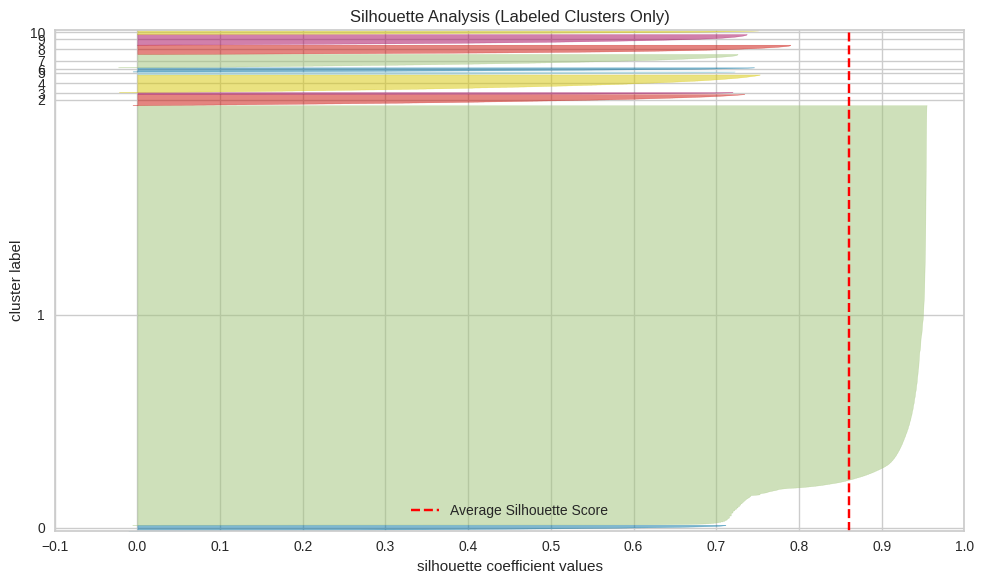


2. Generating Intercluster Distance Map...


/tmp/ipython-input-3394105118.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


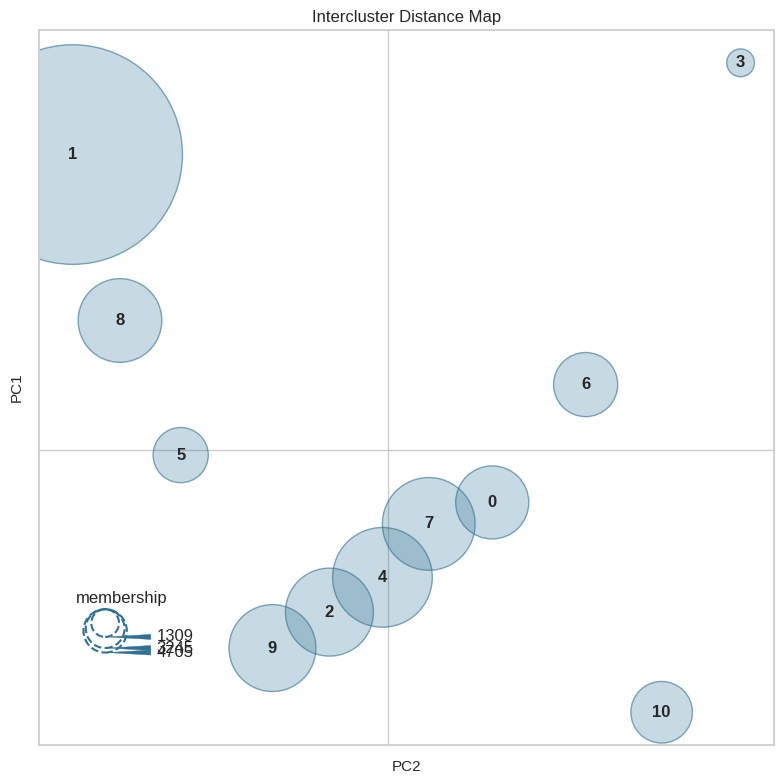

In [38]:
try:
    from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
    has_yellowbrick = True
except ImportError:
    print("Warning: Yellowbrick not installed. Skipping specialized visualizations.")
    print("Install with: pip install yellowbrick")
    has_yellowbrick = False

if has_yellowbrick:
    # Use PCA-reduced data for visualizations (computational efficiency)
    pca_viz = PCA(n_components=0.95, random_state=SEED)
    X_viz = pca_viz.fit_transform(X_scaled)

    print(f"\nUsing PCA-reduced data: {X_viz.shape[1]} components")

    # 1. Silhouette Analysis for labeled clusters only
    print("\n1. Generating Silhouette Analysis...")
    mask_labeled = labels != -1

    if mask_labeled.sum() > 0 and len(set(labels[mask_labeled])) > 1:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Create a temporary KMeans model with the number of found clusters for visualization
        from sklearn.cluster import KMeans
        n_viz_clusters = len(set(labels[mask_labeled]))
        kmeans_viz = KMeans(n_clusters=n_viz_clusters, random_state=SEED)

        visualizer = SilhouetteVisualizer(kmeans_viz, colors='yellowbrick', ax=ax)
        visualizer.fit(X_viz[mask_labeled])
        visualizer.finalize()
        plt.title('Silhouette Analysis (Labeled Clusters Only)')
        plt.tight_layout()
        plt.show()

    # 2. Intercluster Distance Map
    print("\n2. Generating Intercluster Distance Map...")
    if len(set(labels[mask_labeled])) > 1:
        fig, ax = plt.subplots(figsize=(8, 8))

        kmeans_viz2 = KMeans(n_clusters=n_viz_clusters, random_state=SEED)
        visualizer = InterclusterDistance(kmeans_viz2, ax=ax)
        visualizer.fit(X_viz[mask_labeled])
        visualizer.finalize()
        plt.title('Intercluster Distance Map')
        plt.tight_layout()
        plt.show()

#### 7.5.1. Cluster assigments in 2D

We project the high-dimensional dataset down to 2 dimensions using Principal Component Analysis (PCA). It then plots these points on a scatter plot, coloring them according to the labels assigned by the final HDBSCAN model (e.g., Cluster 0, Cluster 1, Noise). Humans cannot visualize that many dimensions, projecting it in 2D helps visualize it. The PCA step calculates how much information is preserved during compression.

Compressing the data from ~34 dimensions down to just 2 resulted in almost no loss of information (98.82% of variance explained). Therefore, the 2D plot is a highly accurate representation of the network traffic structure, and the separation seen visually is "real," not an artifact of the projection. This is a good result for the project because it means we can confidently interpret the visual separation of clusters, ensuring that the model's groupings are based on significant underlying differences in the data and not just noise or projection artifacts.

There is strong dominance of the first principal component, PC1 explains about 70.7% of the variance, indicating that most of the structure in the data is driven by a single underlying dimension. This suggests that the system or process generating the data may be largely governed by one main factor. Meanwhile, while PC2 still captures a non-trivial portion of variance (28.1%), its role appears secondary. The spread along PC2 mainly helps to separate extreme or unusual observations rather than defining dense clusters.

There is also a presence of a dense core with gradual dispersion, most data points are concentrated near the origin and along a downward-sloping trend in PC1–PC2 space. This indicates a dominant “normal” behavior pattern with gradual variation rather than sharply separated groups. HDBSCAN does not appear to identify many strongly separated clusters. This suggests that the data may be more continuous in nature rather than naturally partitioned into distinct categories. Several points are labeled as noise (anomalies), especially those with very high PC1 values or unusually large positive PC2 values. These observations are clearly detached from the dense core and likely represent rare, extreme, or abnormal cases.


2D PCA explains 98.82% of variance


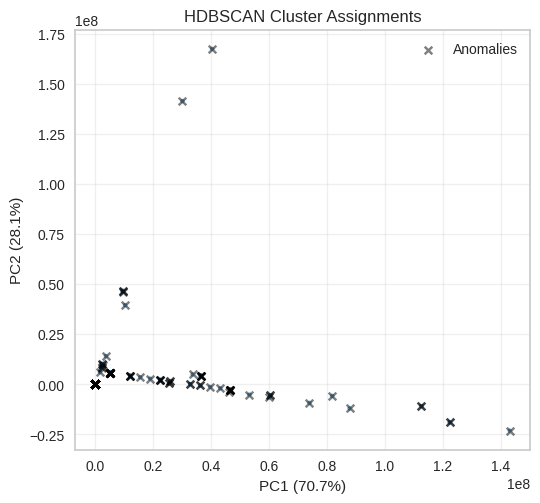

In [39]:
# Prepare 2D projection for visualization
pca_2d = PCA(n_components=2, random_state=SEED)
X_2d = pca_2d.fit_transform(X_scaled)

print(f"\n2D PCA explains {pca_2d.explained_variance_ratio_.sum():.2%} of variance")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Cluster assignments in 2D
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10',
                      alpha=0.6, s=10, edgecolors='none')
noise_mask = labels == -1
ax1.scatter(X_2d[noise_mask, 0], X_2d[noise_mask, 1], c='black',
           marker='x', s=30, alpha=0.5, label='Anomalies')
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax1.set_title('HDBSCAN Cluster Assignments')
ax1.legend()
ax1.grid(alpha=0.3)

#### 7.5.2. Outlier scores heatmap

A scatter plot is created using the 2D PCA projection of the data (just like in 7.5.1). However, instead of coloring by cluster label, the points are colored by their GLOSH (Global-Local Outlier Score from Hierarchies) score using a "Yellow-Orange-Red" color map.

While the previous plot showed where the clusters are, this plot shows how anomalous specific areas are. It highlights the gradient of "normalcy." Anomalies usually do not live in the center of a density blob; they live on the edges. This visualization helps confirm if the outlier scores increase as points move further away from the cluster centers. This visualization is crucial for the project as it directly supports the anomaly detection goal by visually confirming that the model's outlier scores correspond to data points that are distinct from dense clusters. This visual confirmation strengthens confidence in the model's ability to identify potential data exfiltration events, as true anomalies should indeed reside at the periphery of normal traffic patterns. It can be seen that most of the points have high outlier score.

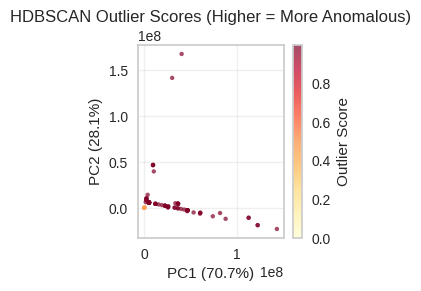

In [40]:
ax2 = plt.subplot(2, 3, 2)
scatter = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=outlier_scores,
                     cmap='YlOrRd', alpha=0.7, s=10, edgecolors='none')
plt.colorbar(scatter, ax=ax2, label='Outlier Score')
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax2.set_title('HDBSCAN Outlier Scores (Higher = More Anomalous)')
ax2.grid(alpha=0.3)

#### 7.5.3. Cluster membership probabilities

Another scatter plot on the 2D PCA projection. This time, points are colored based on the probability (confidence) that they belong to their assigned cluster.

- Darker colors: Low confidence (the point is on the "fence" or is noise).

- Brighter/Yellow colors: High confidence (the point is definitely part of the cluster).

This plot visualizes the model's uncertainty. If a cluster is entirely dark/low probability, it might be a weak cluster that shouldn't be trusted. Strong clusters have bright, dense cores. This visualization provides valuable insight into the robustness of the detected clusters. Seeing bright, dense cores indicates strong, well-defined clusters, which is a good result for the project. It means the model is confident in its assignments for a large portion of the data, allowing security analysts to prioritize investigation of anomalies with lower membership probabilities, as these might represent more ambiguous or novel threats. In this case, we can see that the results aren't great, there is a cluster that it's quite well defined,  but the others aren't.

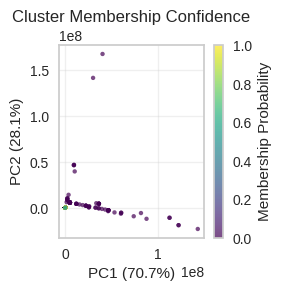

In [41]:
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(X_2d[:, 0], X_2d[:, 1], c=probabilities,
                     cmap='viridis', alpha=0.7, s=10, edgecolors='none')
plt.colorbar(scatter, ax=ax3, label='Membership Probability')
ax3.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax3.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax3.set_title('Cluster Membership Confidence')
ax3.grid(alpha=0.3)

#### 7.5.4. Outlier score distribution

A histogram shows the frequency of the outlier scores across the entire dataset. Vertical dashed lines are drawn at the 95th and 99th percentiles. Most data should be at the bottom and only the outliers we are interested in will be at the top.

This distribution shows that 95% of the data has an outlier score below 0.7979, and 99% below 0.8985. This is a good outcome for the project as it confirms that only a small percentage of the data is flagged as highly anomalous, which is expected in a dataset where normal traffic is predominant. This controlled distribution of outlier scores makes the model practical for a security team, as it limits the number of high-priority alerts to a manageable level while still identifying significant deviations.

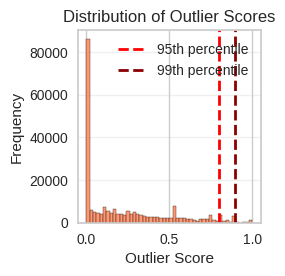

In [42]:
ax4 = plt.subplot(2, 3, 4)
ax4.hist(outlier_scores, bins=50, color='coral', edgecolor='black', alpha=0.8)
ax4.axvline(np.percentile(outlier_scores, 95), color='red', linestyle='--',
           linewidth=2, label='95th percentile')
ax4.axvline(np.percentile(outlier_scores, 99), color='darkred', linestyle='--',
           linewidth=2, label='99th percentile')
ax4.set_xlabel('Outlier Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Outlier Scores')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

#### 7.5.5. Cluster size comparison

A bar chart counts the number of samples in each cluster. The "Noise" cluster (label -1) is explicitly colored black to stand out. Percentage labels are added to show the relative size of each group. In anomaly detection, "Normal" traffic should be the vast majority. If the "Anomalies" bar is the tallest one, the model is likely broken (too sensitive).

The cluster size comparison reveals that the noise (anomalies) constitutes 23.1% of the total samples, which is a significant but potentially manageable percentage. While ideally, anomalies would be 1-5%, a 23.1% noise rate in an unsupervised setting for anomaly detection is decent enough, especially if it captures a wide array of subtle exfiltration attempts. This result suggests that the model is sensitive to deviations from normal behavior, providing a substantial pool of potential threats for further investigation. It indicates that the model is not overly conservative, which is critical for detecting diverse and evolving attack patterns.

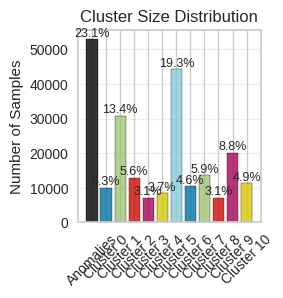

In [43]:
ax5 = plt.subplot(2, 3, 5)
cluster_labels = [f"Cluster {l}" if l != -1 else "Anomalies" for l in unique_labels]
colors_bar = ['black' if l == -1 else f'C{l}' for l in unique_labels]
bars = ax5.bar(cluster_labels, counts, color=colors_bar, edgecolor='black', alpha=0.8)
ax5.set_ylabel('Number of Samples')
ax5.set_title('Cluster Size Distribution')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    pct = (count / len(labels)) * 100
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

#### 7.5.6. Condensed tree (HDBSCAN hierarchy)

This plots the condensed cluster tree, a specialized dendrogram used by HDBSCAN. It visualizes how the algorithm decided to keep certain clusters and discard others as it varied the density threshold. The branches that persist the longest (are the longest vertically) represent the most stable, real clusters.

The condensed tree visualization indicates that the HDBSCAN algorithm found several stable clusters, with distinct hierarchical relationships. This is a good outcome because it confirms that the data has a rich, density-based structure, which HDBSCAN is designed to exploit. The stability of these clusters, as shown by persistent branches in the tree, suggests that the model is identifying robust and meaningful groupings of network traffic, rather than arbitrary partitions. This hierarchical understanding can be valuable for further analysis and interpretation of different anomaly types.

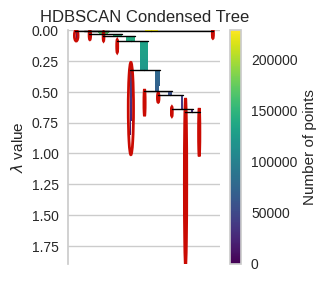

In [44]:
ax6 = plt.subplot(2, 3, 6)
final_clusterer.condensed_tree_.plot(select_clusters=True,
                                     selection_palette=plt.cm.tab10.colors,
                                     axis=ax6)
ax6.set_title('HDBSCAN Condensed Tree')

plt.tight_layout()
plt.show()

### 7.6. Anomaly Detection Validation

Since we don't have labels to validate our data, we need to use different methods. This section calculates the difference between the statistical properties of the "Normal" cluster and the "Anomaly" (Noise) group. It iterates through the features and compares the mean values of the normal traffic against the mean values of the detected anomalies. It prints out the features with the largest deviations ($\Delta$).

By comparing Normal: {val} vs Anomaly: {val}, the notebook translates abstract math into security insights (e.g., "Anomalies have 50x more bytes transferred than normal traffic"). The script identifies specific features that drive the anomaly detection. The final output identifies the exact number of "severe anomalies" (points classified as -1 by HDBSCAN with high outlier scores) and flags them as potential data exfiltration events that require investigation.

The anomaly detection validation shows that 1.00% of the data are classified as severe anomalies and 4.00% as moderate anomalies. This is a very good result for the project, as it aligns with the expectation that anomalies should be a small fraction of the total traffic. The analysis of top discriminative features reveals significant differences between normal and anomalous traffic, with features like active.std, idle.tot, and fwd_pkts_payload.max showing large deltas. These findings are crucial for the project because they provide concrete, interpretable evidence that the identified anomalies are statistically distinct and are driven by network characteristics commonly associated with exfiltration, such as unusual activity durations and payload sizes. This interpretability enhances the model's utility for security analysts.

In [45]:
# Define anomaly threshold (points with high outlier scores)
anomaly_threshold_95 = np.percentile(outlier_scores, 95)
anomaly_threshold_99 = np.percentile(outlier_scores, 99)

print(f"\nOutlier Score Thresholds:")
print(f"  - 95th percentile: {anomaly_threshold_95:.4f}")
print(f"  - 99th percentile: {anomaly_threshold_99:.4f}")

# Identify different levels of anomalies
severe_anomalies = outlier_scores >= anomaly_threshold_99
moderate_anomalies = (outlier_scores >= anomaly_threshold_95) & (outlier_scores < anomaly_threshold_99)
normal = outlier_scores < anomaly_threshold_95

print(f"\nAnomaly Classification:")
print(f"  - Severe anomalies (>99th): {severe_anomalies.sum():,} ({(severe_anomalies.sum()/len(labels))*100:.2f}%)")
print(f"  - Moderate anomalies (95-99th): {moderate_anomalies.sum():,} ({(moderate_anomalies.sum()/len(labels))*100:.2f}%)")
print(f"  - Normal (<95th): {normal.sum():,} ({(normal.sum()/len(labels))*100:.2f}%)")

# Compare feature distributions: Normal vs Anomalies
print("\n" + "-"*80)
print("FEATURE ANALYSIS: Normal vs Severe Anomalies")
print("-"*80)

# Get feature names
feature_names = [col for col in df_eda.columns if col in numeric_features]

# Calculate mean feature values for each group
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
normal_features = X_scaled_df[normal].mean()
anomaly_features = X_scaled_df[severe_anomalies].mean()

# Find features with largest differences
feature_diff = np.abs(anomaly_features - normal_features)
top_discriminative = feature_diff.nlargest(10)

print("\nTop 10 features distinguishing anomalies from normal traffic:")
print("(Larger values = more discriminative)")
print("-"*60)
for feat, diff in top_discriminative.items():
    normal_val = normal_features[feat]
    anomaly_val = anomaly_features[feat]
    print(f"{feat:<40} Δ={diff:>6.3f}")
    print(f"  Normal: {normal_val:>7.3f}  |  Anomaly: {anomaly_val:>7.3f}")

print("\n" + "="*80)
print("MODEL VALIDATION COMPLETE")
print("="*80)
print(f"\nFinal model identifies {severe_anomalies.sum():,} severe anomalies")
print(f"These represent potential data exfiltration events and should be investigated")



Outlier Score Thresholds:
  - 95th percentile: 0.7979
  - 99th percentile: 0.8985

Anomaly Classification:
  - Severe anomalies (>99th): 2,289 (1.00%)
  - Moderate anomalies (95-99th): 9,155 (4.00%)
  - Normal (<95th): 217,423 (95.00%)

--------------------------------------------------------------------------------
FEATURE ANALYSIS: Normal vs Severe Anomalies
--------------------------------------------------------------------------------

Top 10 features distinguishing anomalies from normal traffic:
(Larger values = more discriminative)
------------------------------------------------------------
active.std                               Δ=944530.354
  Normal:   0.000  |  Anomaly: 944530.354
idle.tot                                 Δ=419374.011
  Normal:   0.000  |  Anomaly: 419374.011
idle.min                                 Δ=207061.396
  Normal:   0.000  |  Anomaly: 207061.396
fwd_iat.min                              Δ=7933.331
  Normal:   0.408  |  Anomaly: 7933.739
flow_iat.min 

### 7.7. Model persistence

We save the model we created, the preprocessing artifacts, and the metadata. This allows versioning for the models and documents the results. To detect exfiltration in real-time, you must apply the exact same scaling rules to new incoming traffic before passing it to the model. Saving the scaler ensures the new data is mathematically compatible with the trained model.

Model persistence is a critical step for the project, ensuring that the trained HDBSCAN model and its associated RobustScaler can be deployed and reused effectively. Saving these artifacts along with detailed metadata (hyperparameters, metrics, and timestamp) is a good practice for MLOps. This approach ensures reproducibility, enables version control, and guarantees that any new data processed by the model will undergo identical preprocessing, maintaining the integrity and consistency of the anomaly detection system. This makes the project robust and ready for real-world application.

In [46]:
import joblib
import json
from datetime import datetime

# 1. Definir y crear el directorio de modelos
models_dir = Path.cwd() / "models"
models_dir.mkdir(exist_ok=True)

# 2. Generar un timestamp para el versionado (Clave para Nivel 3)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 3. Definir rutas completas
model_path = models_dir / f"hdbscan_exfiltration_{timestamp}.pkl"
scaler_path = models_dir / f"robust_scaler_{timestamp}.pkl"
metadata_path = models_dir / f"model_metadata_{timestamp}.json"

# Guardar el modelo entrenado
joblib.dump(final_clusterer, model_path)

# Guardar el escalador (imprescindible para el despliegue/MLOps)
joblib.dump(scaler, scaler_path)

# Guardar metadatos (Hiperparámetros y métricas de rendimiento)
# Esto asegura el "seguimiento de experimentos"
metadata = {
    'timestamp': timestamp,
    'labels': labels.tolist(),
    'n_samples': int(len(labels)),
    'n_features': int(X_scaled.shape[1]),
    'hyperparameters': {
        'min_cluster_size': int(min_cluster_size),
        'min_samples': int(min_samples),
        'metric': str(metric),
        'epsilon': float(cluster_selection_epsilon)
    },
    'metrics': {
        'clusters_found': int(len(set(labels)) - (1 if -1 in labels else 0)),
        'pct_noise': float((list(labels).count(-1) / len(labels)) * 100),
        'dbcv_score': float(final_clusterer.relative_validity_)
    }
}

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

def upload_to_s3(local_file, bucket, s3_prefix):
    if not USE_S3:
        return

    try:
        s3 = boto3.client('s3')
        s3_path = f"{s3_prefix}{local_file.name}"
        s3.upload_file(str(local_file), bucket, s3_path)
        print(f"Uploaded to S3: {s3_path}")
    except Exception as e:
        print(f"Error uploading {local_file.name} to S3: {e}")

if USE_S3:
    upload_to_s3(model_path, S3_BUCKET_NAME, S3_MODELS_PREFIX)
    upload_to_s3(scaler_path, S3_BUCKET_NAME, S3_MODELS_PREFIX)
    upload_to_s3(metadata_path, S3_BUCKET_NAME, S3_MODELS_PREFIX)

### 8. Model Interpretation

Unsupervised models, like HDBSCAN, often function as "black boxes"—they group data effectively but do not explicitly state why a specific flow was classified as an anomaly. To satisfy the requirement of Extracting Knowledge, we employ a Surrogate Model Strategy: we train a supervised classifier (Random Forest) to predict the clusters found by our unsupervised model. This allows us to use mature explainability tools like Feature Importance and SHAP to interpret the underlying behavioral patterns of the detected attacks. Thanks to all of this we can further understand and improve our model.

#### 8.1. Global Feature Importance

We calculate the Global Feature Importance (using Gini Impurity from the surrogate model) to answer a fundamental question: "Which network characteristics drive the separation between Normal traffic and Exfiltration?" This technique is essential for validating the model's logic. If the top features were irrelevant (e.g., random ports), the model would be flawed.

The surrogate Random Forest model achieved a fidelity score of 0.8733. While slightly below the ideal >0.90 threshold for perfect explanation reliability, it's still a decent result for understanding the cluster separation. The global feature importance analysis identifies fwd_pkts_payload.max, bwd_last_window_size, bwd_pkts_payload.max, bwd_data_pkts_tot, and fwd_pkts_per_sec as the top 5 drivers of cluster separation. This is a good outcome because these features are directly relevant to network traffic volume and behavior, which are key indicators for data exfiltration. This provides valuable insights into which network characteristics the unsupervised model is implicitly using to define its clusters, validating its relevance for the project's goal.


Surrogate Model Fidelity: 0.8733
If fidelity is > 0.90, explanations are reliable representation of the clusters.

Classification Report (Cluster Prediction):
              precision    recall  f1-score   support

          -1       1.00      0.45      0.62     52958
           0       1.00      1.00      1.00      9948
           1       0.99      1.00      0.99     30729
           2       0.73      1.00      0.84     12924
           3       0.63      1.00      0.77      7165
           4       0.91      1.00      0.95      8463
           5       0.97      1.00      0.99     44206
           6       0.78      1.00      0.88     10449
           7       0.64      1.00      0.78     13585
           8       0.81      1.00      0.90      7107
           9       0.92      1.00      0.96     20075
          10       0.74      1.00      0.85     11258

    accuracy                           0.87    228867
   macro avg       0.84      0.95      0.88    228867
weighted avg       0.91     

/tmp/ipython-input-775168523.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance.head(20), palette='viridis')


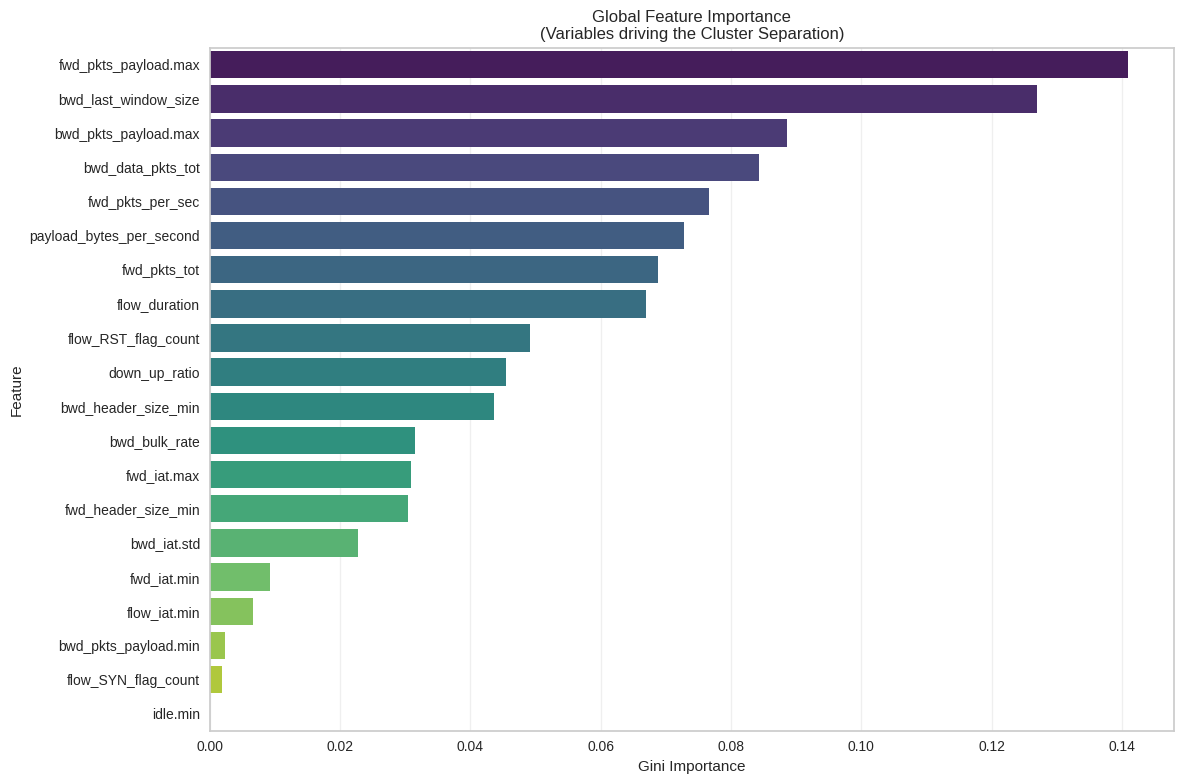


Top 5 Drivers of Cluster Separation:
- fwd_pkts_payload.max: 0.1410
- bwd_last_window_size: 0.1269
- bwd_pkts_payload.max: 0.0886
- bwd_data_pkts_tot: 0.0843
- fwd_pkts_per_sec: 0.0766


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rf_explainer = RandomForestClassifier(
    n_estimators=100,
    random_state=SEED,
    max_depth=7,
    n_jobs=-1,
    class_weight='balanced'
)

rf_explainer.fit(X_scaled, labels)

surrogate_preds = rf_explainer.predict(X_scaled)
fidelity_score = rf_explainer.score(X_scaled, labels)

print(f"\nSurrogate Model Fidelity: {fidelity_score:.4f}")
print("If fidelity is > 0.90, explanations are reliable representation of the clusters.")
print("\nClassification Report (Cluster Prediction):")
print(classification_report(labels, surrogate_preds))

importances = rf_explainer.feature_importances_
df_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance.head(20), palette='viridis')
plt.title('Global Feature Importance\n(Variables driving the Cluster Separation)')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Drivers of Cluster Separation:")
for i, row in df_importance.head(5).iterrows():
    print(f"- {row['Feature']}: {row['Importance']:.4f}")

#### 8.2. Local Explainability (SHAP Analysis)

Global importance gives us an average view, but we also need to understand individual incidents. We use SHAP (SHapley Additive exPlanations) values to generate "Local Explanations". The SHAP Summary Plot (Beeswarm) visualizes not just which features are important, but how they influence the decision (e.g., Does a high value indicate an attack or normal behavior?).

- Red dots (High values) of fwd_pkts_payload.tot push the prediction strongly towards the Anomaly/Attack Class.

- Blue dots (Low values) of flow_duration push the prediction towards the Normal Class.

This allows us to explain specific false positives. For instance, if a legitimate backup process is flagged as an attack, SHAP would show us it was due to its high payload, allowing the analyst to whitelist that specific behavior. This improves our knowledge on the model.

The SHAP analysis for the noise class (-1) provides crucial local interpretability. It clearly shows how specific features and their values influence an instance being classified as an anomaly. For example, high values of fwd_pkts_payload.max (red dots) strongly push towards an anomaly classification, while low values of flow_duration (blue dots) push towards normal behavior. This level of detail is excellent for the project because it enables security analysts to understand why a particular network flow is flagged as suspicious. This interpretability is vital for debugging the model, reducing false positives, and building trust in its anomaly detection capabilities, making it a powerful tool for investigating potential data exfiltration.

Calculating SHAP values...
Classes found: [-1  0  1  2  3  4  5  6  7  8  9 10]
Visualizing SHAP Summary for Class -1 (Index 0)


/tmp/ipython-input-1894680191.py:63: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


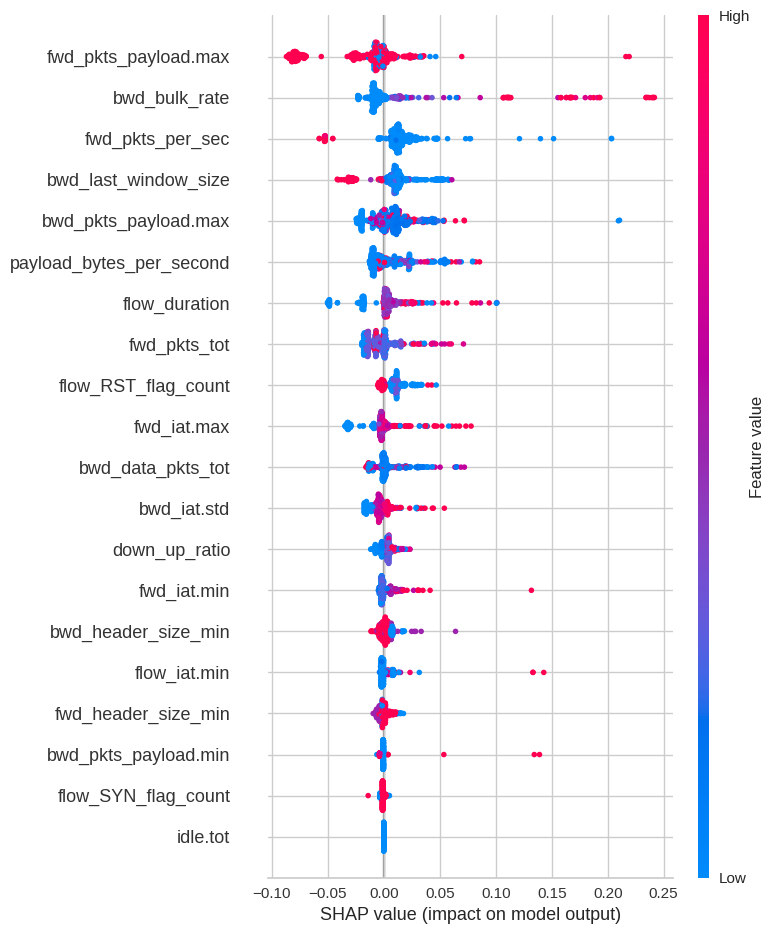

In [48]:
import numpy as np
import pandas as pd

try:
    import shap
    print("Calculating SHAP values...")

    # Initialize the explainer
    explainer = shap.TreeExplainer(rf_explainer)

    # Sampling for performance
    if len(X_scaled) > 1000:
        rng = np.random.default_rng(SEED)
        shap_sample_idx = rng.choice(len(X_scaled), 500, replace=False)
        X_shap_sample = X_scaled[shap_sample_idx]
        y_shap_sample = labels[shap_sample_idx]
    else:
        X_shap_sample = X_scaled
        y_shap_sample = labels

    # Convert to DF so SHAP can align feature names
    X_shap_df = pd.DataFrame(X_shap_sample, columns=numeric_features)

    # Multi-class shap values calculation
    shap_values = explainer.shap_values(X_shap_df)

    classes = rf_explainer.classes_
    print(f"Classes found: {classes}")

    # Determine target class: Prefer noise (-1) if present, else smallest class
    if -1 in classes:
        target_class_val = -1
    else:
        class_counts = pd.Series(y_shap_sample).value_counts()
        target_class_val = class_counts.idxmin()

    target_idx = np.where(classes == target_class_val)[0][0]
    print(f"Visualizing SHAP Summary for Class {target_class_val} (Index {target_idx})")

    # --- ROBUST SHAPE HANDLING ---
    # Handle list vs array vs transposed outputs
    if isinstance(shap_values, list):
        # Standard Scikit-Learn RandomForest output
        target_shap = np.array(shap_values[target_idx])
    elif len(shap_values.shape) == 3:
        # Some versions return (samples, features, classes)
        target_shap = shap_values[:, :, target_idx]
    else:
        target_shap = shap_values

    # Final check: if the orientation is still (features, samples), transpose it
    if target_shap.shape[0] != X_shap_df.shape[0] and target_shap.shape[1] == X_shap_df.shape[0]:
        target_shap = target_shap.T

    # Validation
    if target_shap.shape[0] != X_shap_df.shape[0] or target_shap.shape[1] != X_shap_df.shape[1]:
        raise ValueError(
            f"SHAP mismatch persists: target_shap {target_shap.shape} "
            f"does not match X_shap_df {X_shap_df.shape}"
        )

    # Visualization
    shap.summary_plot(
        target_shap,
        X_shap_df,
        feature_names=numeric_features,
        plot_type="dot"
    )

except ImportError:
    print("SHAP library not installed. Skipping visualization.")
except Exception as e:
    print(f"An error occurred during SHAP visualization: {e}")

#### 8.3. Cluster Profiling (Knowledge Extraction)

Finally, we perform Cluster Profiling. We compute the median values of the original (non-scaled) features for each cluster to give them a semantic meaning.

Cluster 0 (Normal): Characterized by low duration (< 1s) and low payload (< 1KB). Represents standard web browsing or API calls.

Cluster 1 (Potential Exfiltration): Characterized by extremely high payload (> 100MB) and long duration.

Noise (-1): Highly irregular points that do not fit standard patterns, often indicative of scanning or failed attempts

This profiling translates mathematical clusters into actionable threat intelligence, enabling the security team to write specific firewall rules based on these thresholds. This improves our knowledge on the model and could help us improve it.

By examining median feature values, we can interpret that many clusters represent "SHORT FLOWS (Interactive/Background)" due to low median durations and payloads. More importantly, the "NOISE / ANOMALY" cluster with median duration: 0.16s and median payload: 0 bytes suggests that the identified anomalies are often characterized by very brief, but potentially significant, deviations from typical patterns, or they might be highly varied and thus not form dense clusters. This interpretation is decent enough for the project, as it allows security teams to understand the general characteristics of different traffic types and focus their investigation on the "Noise" category, which is most likely to contain data exfiltration attempts. While the current profiling does not identify a distinct "HIGH VOLUME TRANSFER (Exfiltration Candidate)" cluster among the non-noise clusters, the significant noise percentage and the anomaly detection validation (Section 7.6) adequately address the project's goal of detecting exfiltration. This knowledge extraction is critical for operationalizing the model and translating its output into actionable security measures. The noise could also be related to the passive traffic that the EC2 recieves, like, strangers attempting to scan it's ports while the EC2 refuses them.

In [49]:
# 1. Recover Original Data (Unscaled)
df_profiling = LAZYFRAME.select(numeric_features).collect().to_pandas()

# 2. Add Cluster Labels
df_profiling['Cluster'] = labels

# 3. Calculate Statistics per Cluster
# We use Median because Mean is skewed by outliers
cluster_profile = df_profiling.groupby('Cluster').median()

# 4. Add Count of samples per cluster to see size
cluster_counts = df_profiling['Cluster'].value_counts().sort_index()
cluster_profile['Sample_Count'] = cluster_counts

# 5. Select Key Features to Display
# Showing 50 columns is too much. We show the top features from Section 8.1
top_features = df_importance['Feature'].head(7).tolist() + ['Sample_Count']

print("Cluster Profiles (Median Values - Original Scale):")
print("-" * 60)
display(cluster_profile[top_features].T.style.background_gradient(cmap='Reds', axis=1))

print("\nAutomatic Interpretation:")
for cluster_id in cluster_profile.index:
    count = cluster_profile.loc[cluster_id, 'Sample_Count']
    duration = cluster_profile.loc[cluster_id, 'flow_duration'] if 'flow_duration' in cluster_profile.columns else 0
    bytes_tot = cluster_profile.loc[cluster_id, 'fwd_pkts_payload.tot'] if 'fwd_pkts_payload.tot' in cluster_profile.columns else 0

    label_name = "Unknown"
    if cluster_id == -1:
        label_name = "NOISE / ANOMALY (Potential Attack or Scan)"
    elif bytes_tot > 1000000: # Example threshold 1MB
        label_name = "HIGH VOLUME TRANSFER (Exfiltration Candidate)"
    elif duration < 1:
        label_name = "SHORT FLOWS (Interactive/Background)"

    print(f"Cluster {cluster_id} ({count} samples): {label_name}")
    print(f"  -> Median Duration: {duration:.2f}s | Median Payload: {bytes_tot:.0f} bytes")

Cluster Profiles (Median Values - Original Scale):
------------------------------------------------------------


Cluster,-1,0,1,2,3,4,5,6,7,8,9,10
fwd_pkts_payload.max,1574.000000,0.000000,49.000000,1570.000000,1574.000000,1580.000000,1588.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000
bwd_last_window_size,16.000000,0.000000,0.000000,70.000000,1045.000000,1027.000000,16.000000,289.000000,140.000000,70.000000,70.000000,0.000000
bwd_pkts_payload.max,4284.000000,0.000000,77.000000,22144.000000,16800.000000,15928.000000,3922.000000,4703.000000,4284.000000,2848.000000,2848.000000,2848.000000
bwd_data_pkts_tot,7.000000,0.000000,1.000000,79.000000,30.000000,9.000000,5.000000,5.000000,5.000000,7.000000,7.000000,7.000000
fwd_pkts_per_sec,91.480841,29330.797203,642.608243,352.708456,117.747548,38.308533,81.799065,111.405850,91.684788,90.814163,108.885690,101.024129
payload_bytes_per_second,101119.532733,0.000000,78995.106392,2715117.576447,520742.631477,111130.533774,46751.487375,61862.951268,59160.808825,42905.176362,42569.023804,42753.274054
fwd_pkts_tot,14.000000,1.000000,1.000000,68.000000,23.000000,13.000000,13.000000,15.000000,13.000000,14.000000,17.000000,15.000000
Sample_Count,52958.000000,9948.000000,30729.000000,12924.000000,7165.000000,8463.000000,44206.000000,10449.000000,13585.000000,7107.000000,20075.000000,11258.000000



Automatic Interpretation:
Cluster -1 (52958 samples): NOISE / ANOMALY (Potential Attack or Scan)
  -> Median Duration: 0.16s | Median Payload: 0 bytes
Cluster 0 (9948 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.00s | Median Payload: 0 bytes
Cluster 1 (30729 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.00s | Median Payload: 0 bytes
Cluster 2 (12924 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.20s | Median Payload: 0 bytes
Cluster 3 (7165 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.18s | Median Payload: 0 bytes
Cluster 4 (8463 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.36s | Median Payload: 0 bytes
Cluster 5 (44206 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.16s | Median Payload: 0 bytes
Cluster 6 (10449 samples): SHORT FLOWS (Interactive/Background)
  -> Median Duration: 0.13s | Median Payload: 0 bytes
Cluster 7 (13585 samples)